<h1 align='center'>  Bosque Aleatorio </h1> 

Un modelo Random Forest está formado por un conjunto (ensemble) de árboles de decisión individuales, cada uno entrenado con una muestra aleatoria extraída de los datos de entrenamiento originales mediante bootstrapping). Esto implica que cada árbol se entrena con unos datos ligeramente distintos. En cada árbol individual, las observaciones se van distribuyendo por bifurcaciones (nodos) generando la estructura del árbol hasta alcanzar un nodo terminal. La predicción de una nueva observación se obtiene agregando las predicciones de todos los árboles individuales que forman el modelo.

Para entender cómo funcionan los modelos Random Forest es necesario conocer primero los conceptos de ensemble y bagging.

## Ejemplo de un Bosque Aleatorio

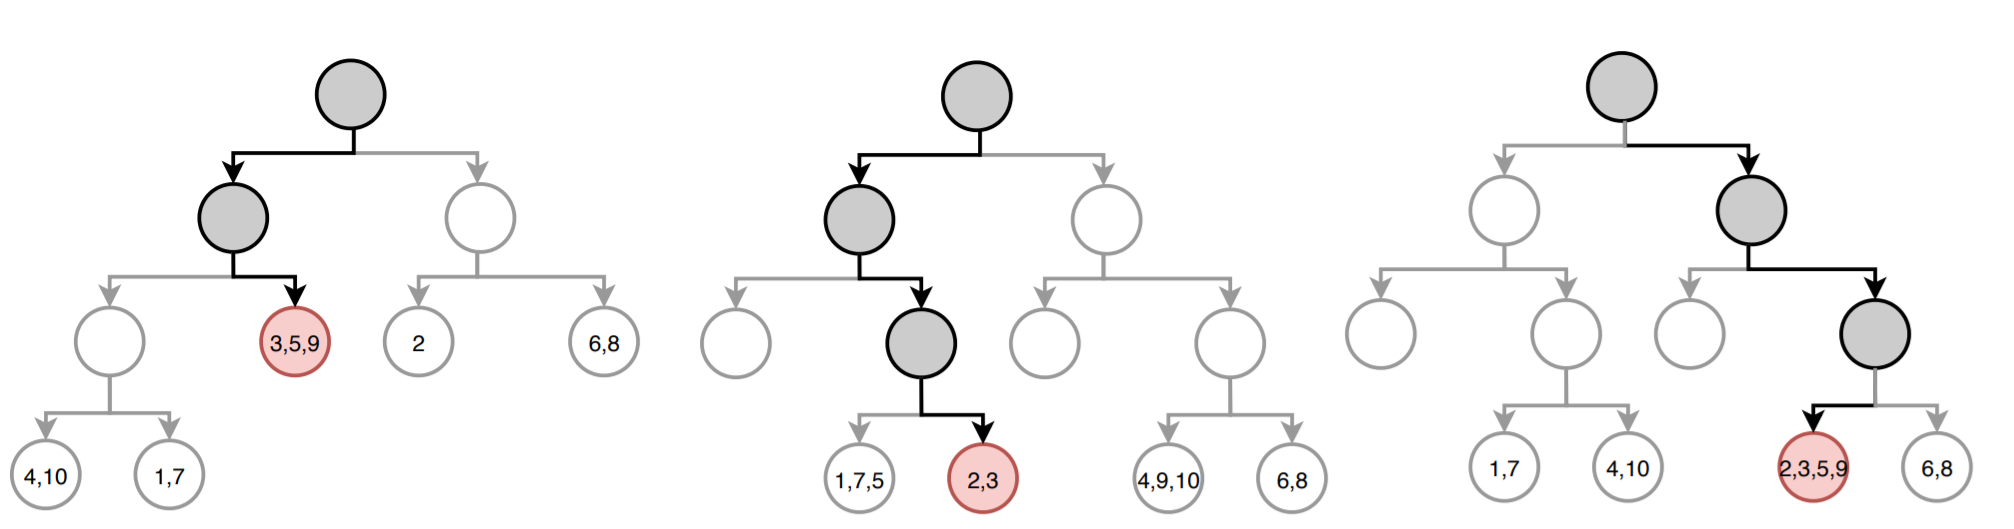

<h2> Mapa </h2>
<ul>
    <li>1-. Formular la pregunta y determinar el modelo</li>
    <li>2-. Adquisición de datos</li>
    <li>3-. Identificación y corrección de los puntos de datos faltantes/anomalías según sea necesario</li>
    <li>4-. Preprocesar los datos</li>
    <li>5-. Entrenar el modelo en los datos de entrenamiento</li>
    <li>6-. Predicciones sobre los datos de prueba y metricas de rendimiento</li>
    <li>7-. Comparar las predicciones con los objetivos conocidos del conjunto de pruebas y calcule las métricas de rendimiento</li>
    <li>8-. Importancia de los predictores</li>
</ul>

# Colección de datos de entrada
Para empezar, debemos implementar los pasos sugeridos en la sección 4.1 en el mismo orden que se nos presenta. Los pasos 1, 2 y 3 son comunes para todos los algoritmos, por ende, solo se mostrará una vez en la presente investigación. Al finalizar esta sección se verán los pasos 4, 5 y 6 en cada Algoritmo presentado.

In [1]:
# Libreria para la manipulación de los datos
import pandas as pd
import numpy as np

# Leer el dataframe
dataframe = pd.read_excel('../bdd/bdd_final.xlsx')
print(dataframe)

   CLAVE      COMUNA         TELEFONOS   FICHA CLINICA     CTA CTE  EDAD  \
0      1  san carlos                NaN   2.012418e+09  11998898.0  53.0   
1      2    coihueco  41723921-74822219   2.000150e+09  12002852.0  54.0   
2      3     chillan  71818219-50323843   9.808599e+07  12003092.0  78.0   
3      4    coihueco  77107584-93406930   9.772094e+06  11995391.0  87.0   
4      5      yungay  99240760-77884029   9.809511e+07  12014450.0  69.0   
..   ...         ...                ...            ...         ...   ...   
70    73  portezuelo  54630728-94220450   9.809299e+07  12536312.0   NaN   
71    74     chillan                NaN   2.010393e+09  12556475.0  86.0   
72    75       pinto           82525308   9.808314e+07  12556991.0  79.0   
73    76     chillan  50711724-87107760   2.000137e+09  12557079.0  54.0   
74  TENS     chillan  85226191-96473857   2.008345e+09  12314495.0  69.0   

     PESO  TALLA  HTA DIABETES  ...   logVEGF   logPlGF    logPCR  \
0     NaN    NaN  

In [2]:
# Mostramos las variables que posee la base de datos
columns_names = dataframe.columns.values
print(columns_names)

['CLAVE' 'COMUNA' 'TELEFONOS ' 'FICHA CLINICA' 'CTA CTE' 'EDAD' 'PESO'
 'TALLA' 'HTA' 'DIABETES' 'OTRAS PATOLOGIAS' 'FUMA' 'FC' 'PAS' 'PAD'
 'GLUCOSA' 'Hb A/C  %' 'COL. TOTAL' 'TRIGLICERIDOS' 'LDL' 'HDL' 'HCTO'
 'HB' 'VCM' 'HCM' 'VHS' 'PLAQUETAS' 'INR' 'CONTEO G.B.' 'P.C.R'
 'Nitrogeno Ureico' 'Uremia' 'Creatinina' 'TTPA' 'TP' 'NA' 'K' 'CL'
 'Fosfatasa Alcalina' 'Gamma glutamil' 'Transaminasa piruvica'
 'Trans oxal' 'AREA DE LESION ' 'No  ESTENOSIS INTRACRANEAL'
 'No  ESTENOSIS EXTRACRANEAL' '%  ESTENOSIS INTRACRANEAL'
 '%  ESTENOSIS EXTRACRANEAL' 'GLASGOW AL INICO ACV' 'NIHSS INICO ACV'
 'RANKIN INICIO ACV' 'NIHSS alta ACV' 'RANKIN alta ACV' 'NIHSS 6M'
 'RANKIN 6M' 'diag Elopez' 'DIAG. NEUROLOGICO' 'Diag2' 'Diag3'
 'FECHA TOMA MUESTRA' 'Estado paciente' 'Fecha defuncion'
 'CAUSA  DEFUNCION ' 'MOTIVO DE DESCARTE ' 'TROMBOLISIS' 'eduardo'
 'sirve ' 'escala' 'exosomes 1' 'exosomes 2' 'VEGF ab1' 'VEGF ab2'
 'VEGF prome' 'plgf mg prot' 'plgf mg prot.1' 'plgf promedio' 'logVEGF'
 'logPlGF' 

Mostramos la cantidad de pacientes y variables(columnas) que posee la BDD:

In [3]:
print('Existen {} pacientes con {} variables.'.format(*dataframe.shape))
print("Existen", dataframe.size, "elementos")

Existen 75 pacientes con 85 variables.
Existen 6375 elementos


Se observa que la BDD posee muchas variables y pocos pacientes registrados en las tuplas. Esto hará que sea más difícil la predicción para los algoritmos, así que necesitamos un nuevo instrumento. 

## Diseño del instrumento
Desde el punto de vista científico, para que un estudio salga lo más certero posible necesitamos variables significativas para la investigación y con la menor perdida de datos posible. En la BDD todas las variables presentan importancia, algunas son imprescindibles para la investigación, otras con pocos datos completados o simplemente las variables sujetas a interpretación médica (humana). Debido a lo anterior se seleccionaron las variables por dos motivos, el primero fue porque eran las que estaban más completas en la BDD y el segundo porque se determinó que eran más significativas para la investigación por estudios realizados al ACV y dataset presentes en internet. A continuación, se mostrarán las variables escogidas y una pequeña descripción de ellas.

>**HTA**: ```"si" o "no", HIPERTENSIÓN```

>**DIABETES**: ```"si" o "no"```

>**EDAD**: ```Edad del paciente```

>**GLUCOSA**: ```Nivel de azucar en la sangre```

>**COL. TOTAL**: ```Cantidad de Colesterol en la sangre```

>**TRIGLICERIDOS**: ```Cantidad de trigliceridos en la sangre```

>**INR**: ```Índice internacional normalizado (INR, por sus siglas en inglés) es un tipo de cálculo que se basa en los resultados de las pruebas de tiempo de protrombina```

>**CONTEO G.B.**: ```Conteo de globulos blancos en la sangre```

>**GLASGOW AL INICO ACV**: ```Escala de 15 puntos medica que es para medir el estado de conciencia. Esta pertence a la Inicial```

>**NIHSS INICO ACV**: ```Escala de 42 puntos más empleada para la valoración de funciones neurológicas básicas en la fase aguda del ictus isquémico, tanto al inicio como durante su evolución. Esta pertence a la Inicial```

>**NIHSS alta ACV**: ```Pertenece cuando es dado de alta el paciente```

La Hipertensión Arterial y la Diabetes son factores de riesgo altos en cualquier enfermedad no trasmisible, por esto son de las primeras seleccionadas,  que además contaremos con las escalas de Glasgow y Nihss que son escalas internacionales para la evaluación del ACV Isquémico. 

# Preparación de los datos de entrada
El segundo paso descrito en la metodología corresponde a la parte más larga de la elaboración para la preparación de la utilización de un modelo de Machine Learning, debido a que este paso todos los datos serán usados como entrada del algoritmo. Aquí se llevará a cabo una identificación y corrección de los puntos de datos faltantes/anomalías según sea necesario.

## Eliminación las filas de los pacientes que se expulsaron de la BDD
Como se indicó anteriormente, se dispone de 75 tuplas con 85 columnas, con un total de 6375 elementos, que se planean disminuir por indicación del médico que facilitó la base de datos. La indicación fue que había pacientes que fueron retirados del programa y estaban marcados con un “out” en la variable de “diag Elopez”.

In [4]:
dataframe.drop(dataframe[(dataframe['diag Elopez'] == 'out')].index, inplace=True)

# mostramos 10 columnas
pd.options.display.max_columns = 10

# Mostramos las primeras 7 tuplas
dataframe.head(7)

,CLAVE,COMUNA,TELEFONOS,FICHA CLINICA,CTA CTE,...,IL-6 (pg/ml),IL-6 corregida,log IL-6,IL-6/VEGF,IL-6/PlGF
0,1,san carlos,NaN,2.012418e+09,11998898.0,...,18.586835,0.156953,-0.804231,-0.454840,-0.825732
1,2,coihueco,41723921-74822219,2.000150e+09,12002852.0,...,1.263441,0.012818,-1.892186,-0.882899,-1.081411
2,3,chillan,71818219-50323843,9.808599e+07,12003092.0,...,49.091862,0.436365,-0.360150,-0.230736,-0.296817
3,4,coihueco,77107584-93406930,9.772094e+06,11995391.0,...,96.544126,0.934859,-0.029254,-0.012974,-0.017620
4,5,yungay,99240760-77884029,9.809511e+07,12014450.0,...,43.309864,0.379102,-0.421244,-0.209021,-0.241949
5,6,chillan,2225404-81923149,2.000139e+09,12015366.0,...,4.897850,0.048574,-1.313598,-0.725090,-0.771829
7,8,chillan,56010835-91599074,2.000149e+09,12032742.0,...,13.519904,0.122450,-0.912042,-0.377564,-0.438164


In [5]:
print('Existen {} pacientes con {} variables.'.format(*dataframe.shape))
print("Existen", dataframe.size, "elementos")

Existen 46 pacientes con 85 variables.
Existen 3910 elementos


## Variables significativas para la investigación 
Ahora asignamos las variables significativas, para esto se extrae la información del marco de trabajo, identificando las variables categóricas para un arreglo completamente nuevo y asi empezar a trabajar sobre el nuevo archivo. 

In [6]:
# Tomaremos las variables más significativas para la investigación
columnasMuestra = ['HTA', 'DIABETES', 'EDAD', 'GLUCOSA', 'COL. TOTAL', 'TRIGLICERIDOS', 'INR', 'CONTEO G.B.', 'GLASGOW AL INICO ACV', 'NIHSS INICO ACV', 'NIHSS alta ACV']
dataset = dataframe[[*columnasMuestra]]

# Muestramos las columnas que se ajusten a la cantidad de espacio
pd.options.display.max_columns = 0

dataset.head(5)

,HTA,DIABETES,EDAD,GLUCOSA,COL. TOTAL,TRIGLICERIDOS,INR,CONTEO G.B.,GLASGOW AL INICO ACV,NIHSS INICO ACV,NIHSS alta ACV
0,NaN,NaN,53.0,137.09,268.0,130.0,1.08,41.9,11.0,14.0,42.0
1,si,si,54.0,NaN,187.0,130.0,NaN,8.3,15.0,6.0,0.0
2,si,si,78.0,359.42,159.0,97.0,0.89,8.5,15.0,5.0,2.0
3,si,si,87.0,186.20,193.0,133.0,0.90,7.0,15.0,1.0,0.0
4,si,si,69.0,170.00,184.0,137.0,1.28,12.1,15.0,3.0,2.0


Mostramos la cantidad de pacientes y variables(columnas) que posee la BDD después de la selección de variables significativas para la investigación:

In [7]:
print('Existen {} pacientes con {} variables.'.format(*dataset.shape))
print("Existen", dataset.size, "elementos")

Existen 46 pacientes con 11 variables.
Existen 506 elementos


## Descripción general de los datos
En la descripción de los datos, se muestran parámetros, perdida de datos (Missing Data), forma y su descripción estadística.

In [8]:
# Check Dataset:
def check_data(dataset,head=5):
    print(20*"-" + "Información".center(20) + 20*"-")
    print(dataset.info())
    print(20*"-" + "Forma de datos".center(20) + 20*"-")
    print(dataset.shape)
    print("\n" + 20*"-" + "Los primeros 5 datos".center(20) + 20*"-")
    print(dataset.head())
    print("\n" + 20 * "-" + "Los últimos 5 datos".center(20) + 20 * "-")
    print(dataset.tail())
    print("\n" + 20 * "-" + "Missing Data".center(20) + 20 * "-")
    print(dataset.isnull().sum())
    print("\n" + 20 * "-" + "Describir los datos".center(20) + 20 * "-")
    print(dataset.describe().T)
check_data(dataset)

--------------------    Información     --------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 46 entries, 0 to 74
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HTA                   42 non-null     object 
 1   DIABETES              34 non-null     object 
 2   EDAD                  44 non-null     float64
 3   GLUCOSA               38 non-null     float64
 4   COL. TOTAL            40 non-null     float64
 5   TRIGLICERIDOS         40 non-null     float64
 6   INR                   37 non-null     float64
 7   CONTEO G.B.           46 non-null     float64
 8   GLASGOW AL INICO ACV  29 non-null     float64
 9   NIHSS INICO ACV       39 non-null     float64
 10  NIHSS alta ACV        32 non-null     float64
dtypes: float64(9), object(2)
memory usage: 4.3+ KB
None
--------------------   Forma de datos   --------------------
(46, 11)

--------------------Los primeros 5 datos-----

La descripción de los datos nos ayuda a evaluar los casos particulares de las variables que serán tratadas en los siguientes titulos.

## Missing data
Los datos que faltan ocurren cuando no se almacena ningún valor en la variable de observación. Aunque el Missing data es una ocurrencia muy común, estos pueden tener una presión significativa en los resultados de la aplicación del instrumento. Para corregir este problema, existen variadas técnicas estadísticas, siendo una de ellas la mediana y el redondeo como lo muestra Will Kushner en algunas variables que utilizaremos para llenar las celdas faltantes. Tomaremos la información que mostramos anteriormente.

In [9]:
dataset.isnull().sum()

HTA                      4
DIABETES                12
EDAD                     2
GLUCOSA                  8
COL. TOTAL               6
TRIGLICERIDOS            6
INR                      9
CONTEO G.B.              0
GLASGOW AL INICO ACV    17
NIHSS INICO ACV          7
NIHSS alta ACV          14
dtype: int64

En casi todas las variables hay missing data, así que el algoritmo para trabajar será el siguiente:

In [10]:
valores_por_defecto = {
                       'HTA': "DESCONOCIDO",
                       'DIABETES' : "DESCONOCIDO",
                       'EDAD':dataset["EDAD"].median().round(),
                       'GLUCOSA':dataset["GLUCOSA"].median(),
                       'COL. TOTAL':dataset["COL. TOTAL"].median(), 
                       'TRIGLICERIDOS':dataset["TRIGLICERIDOS"].median(),
                       'INR':dataset["INR"].median(),
                       'GLASGOW AL INICO ACV':dataset["GLASGOW AL INICO ACV"].median().round(),
                       'NIHSS INICO ACV':dataset["NIHSS INICO ACV"].median().round(), 
                       'NIHSS alta ACV':dataset["NIHSS alta ACV"].median().round(), 
                      }
# Missing Data
dataset = dataset.fillna(value=valores_por_defecto)

Comprobamos si ahora existe missing data:

In [11]:
dataset.isnull().sum()

HTA                     0
DIABETES                0
EDAD                    0
GLUCOSA                 0
COL. TOTAL              0
TRIGLICERIDOS           0
INR                     0
CONTEO G.B.             0
GLASGOW AL INICO ACV    0
NIHSS INICO ACV         0
NIHSS alta ACV          0
dtype: int64

Como se ve, ya no existe missing data.

## Preprocesamiento de los datos y clasificación
La preparación de los datos para el modelo de aprendizaje automático es lo que nos llevará a decidir qué modelo podremos ocupar, ya que trabajar para modelos de clasificación no es lo mismo que para los de regresión. Los pasos exactos para la preparación de los datos dependerán del modelo utilizado y de los datos recopilados, pero requerirá cierta cantidad de manipulación de datos para cualquier aplicación de aprendizaje automático.

### Análisis de variable Objetivo

La NIHSS es la escala más utilizada para evaluar la función neurológica básica durante la fase aguda del ictus isquémico, tanto en su inicio como en su evolución. Consta de 11 ítem que te permiten explorar rápidamente (Cién escalas de interés en Neurología. Prous Science,2001). Según las puntuaciones obtenidas, podemos dividir la gravedad neurológica en varios grupos: 0: sin déficit; 1: déficit mínimo; 2-5: leve; 6-15: moderado; 15-20: déficit importante; >20: Gravemente ( Montaner 2006). La puntuación global inicial tiene buen valor de pronóstico (Heinemman 1997) (Adams 1999), dado que NIHSS ≤ 6 corresponde a una excelente recuperación neurológica y que cada aumento de punto empeora la evolución. Para los pacientes con fibrilación auricular, se ha considerado que un NIHSS ≥16 tiene un pronóstico muy precario (Frankel 2000). Otra ventaja de esta escala es que puede predecir la respuesta a la terapia trombolítica y estimar la gravedad en función de la puntuación.

La variable más importante que nos interesa tener en la predicción, es la escala Nihss de alta, esto para poder tener un aseguramiento  de la predicción del estado de salud del total de pacientes  a través del camino de salida del hospital, es decir, conoceremos el estado del paciente al salir de alta y según las demás variables existe una tendencia para la predicción en la escala del alta.

In [12]:
dataset["NIHSS alta ACV"].value_counts()

1.0     19
0.0     12
2.0      6
42.0     2
4.0      2
8.0      1
10.0     1
18.0     1
32.0     1
5.0      1
Name: NIHSS alta ACV, dtype: int64

En esta escala los valores menores son los que nos ayudan a tener un mejor pronostico para los pacientes, es por eso que se decide crear una variable con los resultados que da el test NIHSS.

#### Crear columna para NIHSS_alta_cat
Esta columna nos servirá para clasificación de los estados de la variable Nihss.

In [13]:
# Realizamos la clasificación de la escala
condicionesALTA = [
    (dataset['NIHSS alta ACV'] == 0),
    (dataset['NIHSS alta ACV'] == 1),
    (dataset['NIHSS alta ACV'] >= 2) & (dataset['NIHSS alta ACV'] <= 5),
    (dataset['NIHSS alta ACV'] >= 6) & (dataset['NIHSS alta ACV'] <= 15),
    (dataset['NIHSS alta ACV'] >= 16) & (dataset['NIHSS alta ACV'] <= 20),
    (dataset['NIHSS alta ACV'] > 20),
]
valoresALTA = ["Sin Déficit", "Déficit Mínimo", "Leve (Trombolisando)", "Moderado (Buen Pronostico)", "Déficit Importante", "Grave"]
dataset['NIHSS_alta_cat'] = np.select(condicionesALTA, valoresALTA)
dataset['NIHSS_alta_cat'].value_counts()

Déficit Mínimo                19
Sin Déficit                   12
Leve (Trombolisando)           9
Grave                          3
Moderado (Buen Pronostico)     2
Déficit Importante             1
Name: NIHSS_alta_cat, dtype: int64

In [14]:
# Como son muchas columnas, muestro menos columnas
pd.options.display.max_columns = 6

dataset.head(5)

,HTA,DIABETES,EDAD,...,NIHSS INICO ACV,NIHSS alta ACV,NIHSS_alta_cat
0,DESCONOCIDO,DESCONOCIDO,53.0,...,14.0,42.0,Grave
1,si,si,54.0,...,6.0,0.0,Sin Déficit
2,si,si,78.0,...,5.0,2.0,Leve (Trombolisando)
3,si,si,87.0,...,1.0,0.0,Sin Déficit
4,si,si,69.0,...,3.0,2.0,Leve (Trombolisando)


#### Crear columna para NIHSS_alta_ESTABLE_O_GRAVE
Esta columna nos ayudará a observar si el paciente esta estable o crítico. Nos interesa saber el pronóstico del paciente, por eso es necesaria una variable binaria sobre el alta del paciente. Luego de obtener la nueva columna, se comparará con las otras variables.

In [15]:
dataset['NIHSS_alta_ESTABLE_O_GRAVE'] = np.where(dataframe['NIHSS alta ACV'] <=6, 0, 1)

dataset['NIHSS_alta_ESTABLE_O_GRAVE'].value_counts()

0    26
1    20
Name: NIHSS_alta_ESTABLE_O_GRAVE, dtype: int64

Destacamos que si en la escala de Nihss el paciente se encuentra con una valor leve o sin déficit obtendrá el valor 0 binario, al contrario todos los demás obtendrán el valor 1.

In [16]:
dataset.head(5)

,HTA,DIABETES,EDAD,...,NIHSS alta ACV,NIHSS_alta_cat,NIHSS_alta_ESTABLE_O_GRAVE
0,DESCONOCIDO,DESCONOCIDO,53.0,...,42.0,Grave,1
1,si,si,54.0,...,0.0,Sin Déficit,0
2,si,si,78.0,...,2.0,Leve (Trombolisando),0
3,si,si,87.0,...,0.0,Sin Déficit,0
4,si,si,69.0,...,2.0,Leve (Trombolisando),0


### Análisis de las las escalas de INICIO del ACV

#### NIHSS INICO ACV
Esta variable la transformaremos a la categoría que nos ofrece la literatura con sus 6 estados.

In [17]:
# Análisis NIHSS INICO ACV
print(f'NIHSS INICO ACV Variable min: {dataset["NIHSS INICO ACV"].min()}')
print(f'NIHSS INICO ACV Variable max: {dataset["NIHSS INICO ACV"].max()}')
print(f'NIHSS INICO ACV Variable: {dataset["NIHSS INICO ACV"].nunique()}')

NIHSS INICO ACV Variable min: 0.0
NIHSS INICO ACV Variable max: 21.0
NIHSS INICO ACV Variable: 14


In [18]:
# Realizamos la clasificación de la escala
condicionesINICIO = [
    (dataset['NIHSS INICO ACV'] == 0),
    (dataset['NIHSS INICO ACV'] == 1),
    (dataset['NIHSS INICO ACV'] >= 2) & (dataset['NIHSS INICO ACV'] <= 5),
    (dataset['NIHSS INICO ACV'] >= 6) & (dataset['NIHSS INICO ACV'] <= 15),
    (dataset['NIHSS INICO ACV'] >= 16) & (dataset['NIHSS INICO ACV'] <= 20),
    (dataset['NIHSS INICO ACV'] > 20),
]
valoresINICIO = ["Sin Déficit", "Déficit Mínimo", "Leve (Trombolisando)", "Moderado (Buen Pronostico)", "Déficit Importante", "Grave"]
dataset['NIHSS_INICIO_cat'] = np.select(condicionesINICIO, valoresINICIO)
dataset['NIHSS_INICIO_cat'].value_counts()

Leve (Trombolisando)          28
Moderado (Buen Pronostico)    12
Déficit Mínimo                 3
Grave                          1
Déficit Importante             1
Sin Déficit                    1
Name: NIHSS_INICIO_cat, dtype: int64

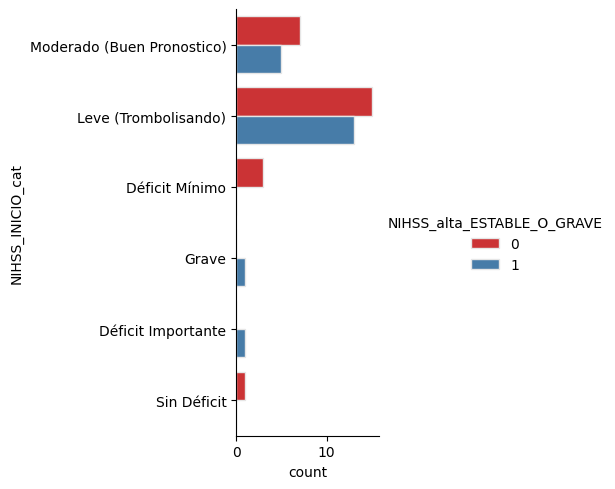

In [19]:
# Para gráficos matpltlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import style

sns.catplot(y="NIHSS_INICIO_cat", hue="NIHSS_alta_ESTABLE_O_GRAVE", kind="count",
            palette="Set1", edgecolor=".9",
            data=dataset);

La realización de la escala fue acorde a los mismos parámetros que la variable objetivo, solo que en este caso dejamos de lado la variable binaria.

Se observa que el valor mínimo que llego un paciente fue de 0 encontrándose Sin Déficit neurológico y el máximo con 21 puntos con un Déficit importante, además se aprecia gracias al grafico que los pronósticos moderado y leve son los que más abundan en la muestra, al mismo se demuestra que esos pacientes al salir de alta en su mayoría tienen un buen pronóstico según la escala de NIHSS.


#### GLASGOW AL INICO ACV
La escala de Glasgow se divide en tres grupos puntuables de manera independiente que evalúan la apertura de ojos sobre 4 puntos, la respuesta verbal sobre 5 y la motora sobre 6, siendo la puntuación máxima y normal 15 y la mínima 3 (The status of the Glasgow Coma Scale). Se considera traumatismo craneoencefálico leve al que presenta un Glasgow de 15 a 13 puntos, moderado de 12 a 9 y grave menor o igual a 8 (Cién escalas de interés en Neurología. Prous Science,2001). A continuación procesaremos la escala.

In [20]:
# Análisis GLASGOW AL INICO ACV
print(f'GLASGOW AL INICO ACV Variable min: {dataset["GLASGOW AL INICO ACV"].min()}')
print(f'GLASGOW AL INICO ACV Variable max: {dataset["GLASGOW AL INICO ACV"].max()}')
print(f'GLASGOW AL INICO ACV Variable: {dataset["GLASGOW AL INICO ACV"].nunique()}')

GLASGOW AL INICO ACV Variable min: 0.0
GLASGOW AL INICO ACV Variable max: 15.0
GLASGOW AL INICO ACV Variable: 7


In [21]:
# Realizamos la clasificación de la escala
dataset['GLASGOW_cat'] = pd.cut(dataset['GLASGOW AL INICO ACV'], bins=[-1, 8, 12, 15], labels=['Grave', 'Moderado', 'Leve'])
dataset['GLASGOW_cat'].unique()

['Moderado', 'Leve', 'Grave']
Categories (3, object): ['Grave' < 'Moderado' < 'Leve']

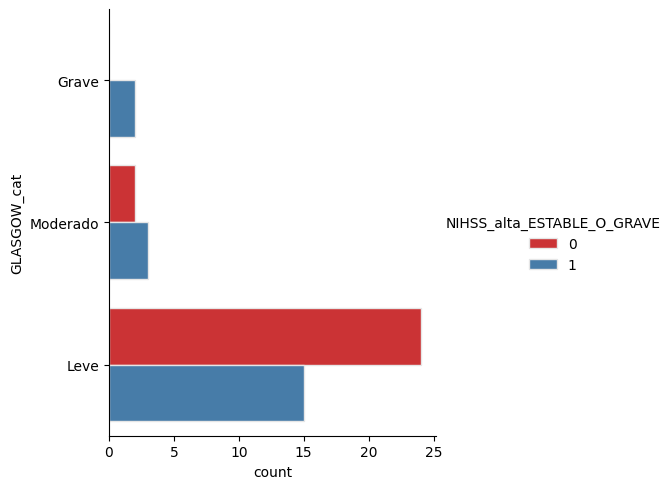

In [22]:
sns.catplot(y="GLASGOW_cat", hue="NIHSS_alta_ESTABLE_O_GRAVE", kind="count",
            palette="Set1", edgecolor=".9",
            data=dataset);

Se observa que el valor mínimo que llego un paciente fue de 0 encontrándose grave neurológico y el máximo con 15 puntos encontrándose leve, además se aprecia gracias al grafico que el pronostico Leve es el que abunda en esta variable, al mismo se demuestra que esos pacientes al salir de alta en su mayoría tienen un buen pronóstico según la escala de NIHSS.

### Análisis de otas variables de médicas
Las siguientes clasificaciones están sacadas del (https://medlineplus.gov/spanish/ency/esp_presentations/100151_3.htm) y Geo Salud, que son páginas que poseen escalas para la clasificación de las variables que veremos.

#### Conteo de Glóbulos Blancos
Los glóbulos blancos son parte del sistema inmunológico del cuerpo y ayudan a combatir infecciones y otras enfermedades. Los registraremos en 3 categorías.

In [23]:
# Análisis CONTEO G.B.
print(f'CONTEO G.B. Variable min: {dataset["CONTEO G.B."].min()}')
print(f'CONTEO G.B. Variable max: {dataset["CONTEO G.B."].max()}')
print(f'CONTEO G.B. Variable: {dataset["CONTEO G.B."].nunique()}')

CONTEO G.B. Variable min: 3.76
CONTEO G.B. Variable max: 41.9
CONTEO G.B. Variable: 38


In [24]:
# Realizamos la clasificación de la escala
dataset['CONTEO G.B._cat'] = pd.cut(dataset['CONTEO G.B.'], bins=[0, 4.5, 10,1000], labels=['Bajo', 'Normal', 'Alto'])
dataset['CONTEO G.B._cat'].unique()

['Alto', 'Normal', 'Bajo']
Categories (3, object): ['Bajo' < 'Normal' < 'Alto']

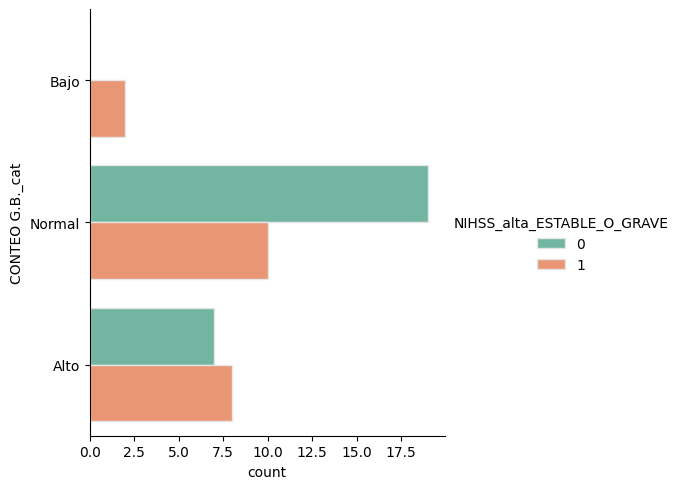

In [25]:
sns.catplot(y="CONTEO G.B._cat", hue="NIHSS_alta_ESTABLE_O_GRAVE", kind="count",
            palette="Set2", edgecolor=".9",
            data=dataset);

Se observa en el grafico que la mayoría de los pacientes están en la categoría normal y ellos tienen en más del 50 \% un buen pronóstico.

#### INR
 El INR sirve para ver la coagulación de la sangre, siendo que esta examen ayuda a saber qué tipo de medicamentos podemos administrar o averiguar la causa de los coágulos sanguíneos anormales.

In [26]:
# Análisis INR
print(f'INR Variable min: {dataset["INR"].min()}')
print(f'INR Variable max: {dataset["INR"].max()}')
print(f'INR Variable: {dataset["INR"].nunique()}')

INR Variable min: 0.89
INR Variable max: 3.08
INR Variable: 26


In [27]:
dataset['INR_cat'] = pd.cut(dataset['INR'], bins=[0.0, 2, 4,1000], labels=['Riesgo', 'Normal', 'No Anticoagula'])
dataset['INR_cat'].unique()

['Riesgo', 'Normal']
Categories (3, object): ['Riesgo' < 'Normal' < 'No Anticoagula']

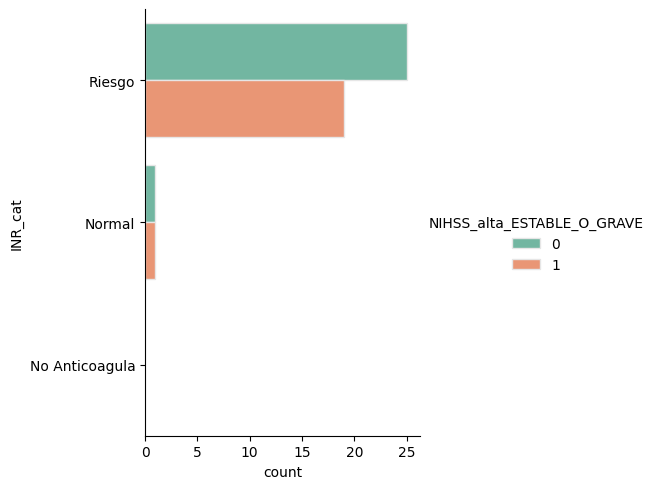

In [28]:
sns.catplot(y="INR_cat", hue="NIHSS_alta_ESTABLE_O_GRAVE", kind="count",
            palette="Set2", edgecolor=".9",
            data=dataset);

Se observa en el grafico que la mayoría de los pacientes están en la categoría de Riesgo, aunque un grupo importante tiene un pronostico favorable. En la categoría Normal no se sabe si el paciente obtuvo un buen o mal pronóstico.

#### Triglicéridos
Los triglicéridos son el principal tipo de grasa que se transporta en la sangre para obtener energía o se almacena en las células del cuerpo según las necesidades energéticas entre comidas.

In [29]:
# Análisis TRIGLICERIDOS
print(f'TRIGLICERIDOS Variable min: {dataset["TRIGLICERIDOS"].min()}')
print(f'TRIGLICERIDOS Variable max: {dataset["TRIGLICERIDOS"].max()}')
print(f'TRIGLICERIDOS Variable: {dataset["TRIGLICERIDOS"].nunique()}')

TRIGLICERIDOS Variable min: 57.0
TRIGLICERIDOS Variable max: 232.0
TRIGLICERIDOS Variable: 31


In [30]:
dataset['TRIGLICERIDOS_cat'] = pd.cut(dataset['TRIGLICERIDOS'], bins=[0, 150, 200, 500, 10000], labels=['Normal', 'Límite alto', 'Alto', 'Muy Alto'])
dataset['TRIGLICERIDOS_cat'].unique()

['Normal', 'Límite alto', 'Alto']
Categories (4, object): ['Normal' < 'Límite alto' < 'Alto' < 'Muy Alto']

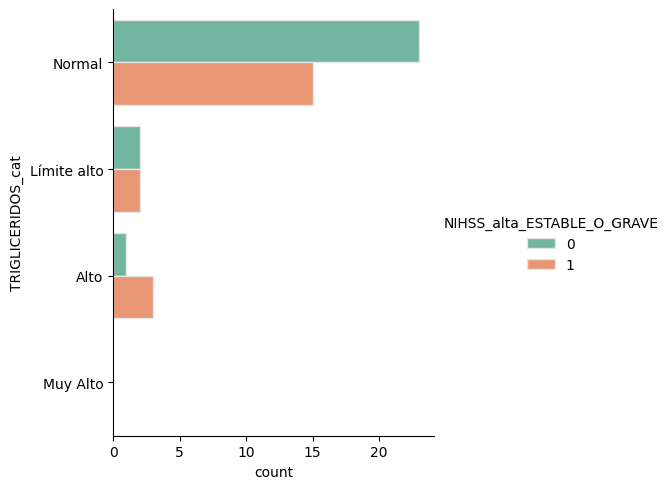

In [31]:
sns.catplot(y="TRIGLICERIDOS_cat", hue="NIHSS_alta_ESTABLE_O_GRAVE", kind="count",
            palette="Set2", edgecolor=".9",
            data=dataset);

El grafico muestra que la mayoría de los pacientes están en la categoría Normal, aunque un grupo importante tiene un pronóstico favorable. En la categoría Alta un gran porcentaje tiene un mal pronóstico con el alta del ACV.

#### Colesterol Total
El colesterol es una grasa natural que se encuentra en todas las células del cuerpo y es necesaria para que el cuerpo funcione correctamente. El colesterol se produce en el hígado en su mayoría, aunque también se puede obtener de algunos alimentos.

In [32]:
# Análisis COL. TOTAL
print(f'COL. TOTAL Variable min: {dataset["COL. TOTAL"].min()}')
print(f'COL. TOTAL Variable max: {dataset["COL. TOTAL"].max()}')
print(f'COL. TOTAL Variable: {dataset["COL. TOTAL"].nunique()}')

COL. TOTAL Variable min: 85.0
COL. TOTAL Variable max: 342.0
COL. TOTAL Variable: 34


In [33]:
dataset['COL. TOTAL_cat'] = pd.cut(dataset['COL. TOTAL'], bins=[0, 150, 400, 1000, 100000], labels=['Normal', 'Límite alto', 'Alto', 'Muy Alto'])
dataset['COL. TOTAL_cat'].unique()

['Límite alto', 'Normal']
Categories (4, object): ['Normal' < 'Límite alto' < 'Alto' < 'Muy Alto']

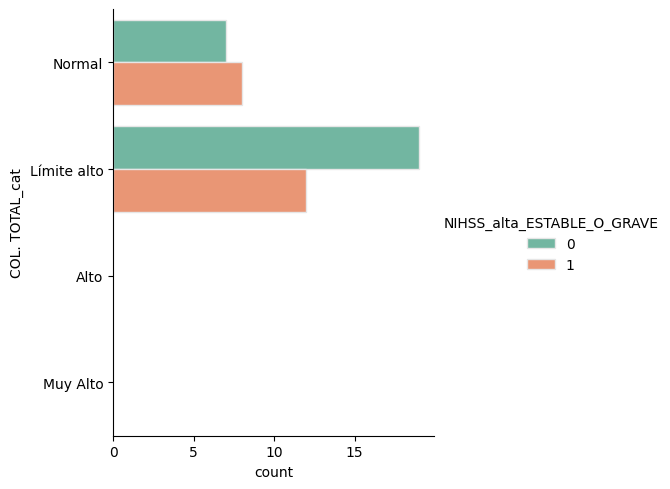

In [34]:
sns.catplot(y="COL. TOTAL_cat", hue="NIHSS_alta_ESTABLE_O_GRAVE", kind="count",
            palette="Set2", edgecolor=".9",
            data=dataset);

El grafico muestra que la mayoría de los pacientes están en la categoría Limite alto, siendo que un grupo importante tiene un pronóstico favorable. 

#### Glucosa
El azúcar en la sangre, es llamada "glucosa", siendo el azúcar principal en la sangre. Proviene de los alimentos que consume y es la principal fuente de energía. Su sangre transporta glucosa a cada célula de su cuerpo para obtener energía.

In [35]:
# Análisis EDAD
print(f'GLUCOSA Variable min: {dataset["GLUCOSA"].min()}')
print(f'GLUCOSA Variable max: {dataset["GLUCOSA"].max()}')
print(f'GLUCOSA Variable: {dataset["GLUCOSA"].nunique()}')

GLUCOSA Variable min: 82.61
GLUCOSA Variable max: 359.42
GLUCOSA Variable: 39


In [36]:
dataset['GLUCOSA_cat'] = pd.cut(dataset['GLUCOSA'], bins=[0, 90, 160, 230, 3000], labels=['Bajo', 'Normal', 'Alto', 'Muy Alto'])
dataset['GLUCOSA_cat'].unique()

['Normal', 'Muy Alto', 'Alto', 'Bajo']
Categories (4, object): ['Bajo' < 'Normal' < 'Alto' < 'Muy Alto']

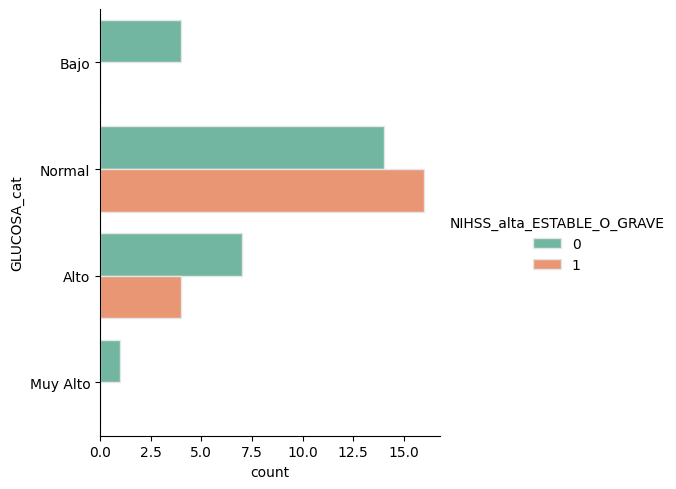

In [37]:
sns.catplot(y="GLUCOSA_cat", hue="NIHSS_alta_ESTABLE_O_GRAVE", kind="count",
            palette="Set2", edgecolor=".9",
            data=dataset);

El grafico muestra que la mayoría de los pacientes están en la categoría Normal, aunque un grupo importante tiene un pronóstico poco favorable en el alta. En la categoría Alta un gran porcentaje importante tiene un buen pronóstico con el alta del ACV.

#### Edad
La edad juega un rol importante para determinar el estado que se puede encontrar el cuerpo para responder a una enfermedad o tratamiento, es por eso que una de las variables que si o si debe estar presente.

In [38]:
# Análisis EDAD
print(f'EDAD Variable min: {dataset["EDAD"].min()}')
print(f'EDAD Variable max: {dataset["EDAD"].max()}')
print(f'EDAD Variable: {dataset["EDAD"].nunique()}')

EDAD Variable min: 38.0
EDAD Variable max: 90.0
EDAD Variable: 28


In [39]:
dataset['EDAD_cat'] = pd.cut(dataset['EDAD'], bins=[0, 13, 18, 45, 60, 100], labels=['Niño', 'Adolecente', 'Adulto Joven', 'Adulto', 'Anciano'])
dataset['EDAD_cat'].unique()

['Adulto', 'Anciano', 'Adulto Joven']
Categories (5, object): ['Niño' < 'Adolecente' < 'Adulto Joven' < 'Adulto' < 'Anciano']

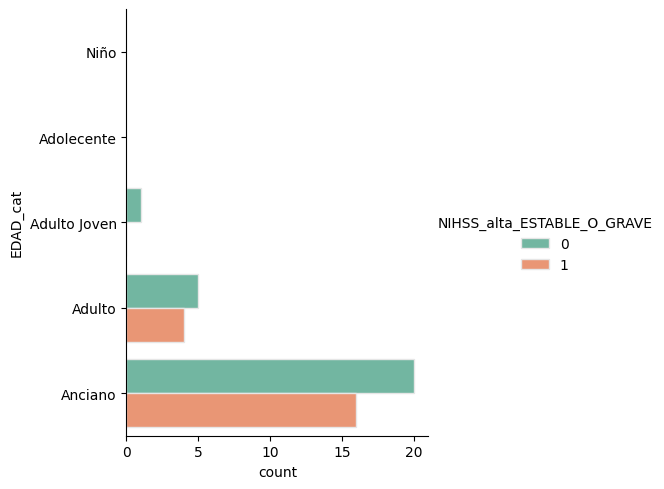

In [40]:
sns.catplot(y="EDAD_cat", hue="NIHSS_alta_ESTABLE_O_GRAVE", kind="count",
            palette="Set2", edgecolor=".9",
            data=dataset);

El grafico muestra que la mayoría de los pacientes que son ancianos pasaron por el ACV, aunque un grupo mayoritario de esa categoría tiene un pronóstico favorable en el alta. En la categoría Adulto es la segunda más grande y si respuesta hacia el alta es muy pareja en los dos pronósticos.

#### Diabetes
La diabetes es una enfermedad crónica que afecta la forma en que el cuerpo convierte los alimentos en energía. El cuerpo descompone la mayor parte de los alimentos que ingiere en azúcar (también llamada glucosa) y la libera en la sangre. Puede existir exceso de azúcar en la sangre o ausencia de azúcar en la sangre.

In [41]:
# Análisis DIABETES

print(f'DIABETES Variable min: {dataset["DIABETES"].min()}')
print(f'DIABETES Variable max: {dataset["DIABETES"].max()}')
print(f'DIABETES Variable: {dataset["DIABETES"].nunique()}')

DIABETES Variable min: DESCONOCIDO
DIABETES Variable max: si
DIABETES Variable: 3


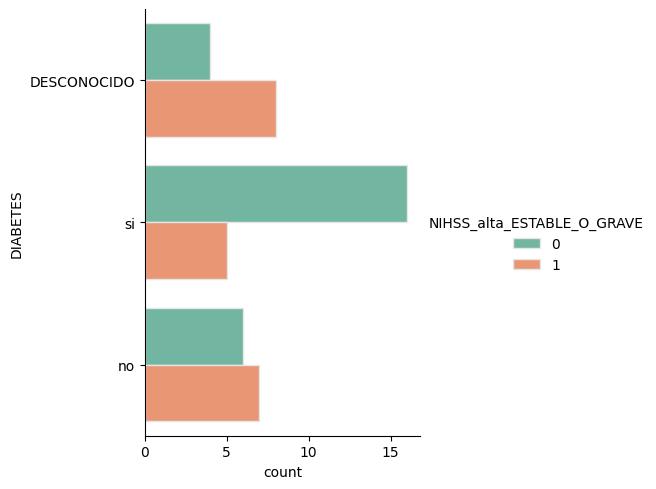

In [42]:
sns.catplot(y="DIABETES", hue="NIHSS_alta_ESTABLE_O_GRAVE", kind="count",
            palette="Set2", edgecolor=".9",
            data=dataset);

En este caso, solo se tomo si el paciente poseía diabetes y los datos desconocidos se tomó como otra variable.

El grafico muestra que la mayoría de los pacientes que tienen diabetes tienen un buen pronóstico al alta. El estado Desconocido posee un pronóstico poco favorable al alta.

#### Hipertensión
La hipertensión es sinónimo de enfermedades cardiacas, siendo que es la fuerza de la presión arterial que trasporta los nutrientes con la sangre.

In [43]:
# Análisis DIABETES

print(f'HTA Variable min: {dataset["HTA"].min()}')
print(f'HTA Variable max: {dataset["HTA"].max()}')
print(f'HTA Variable: {dataset["HTA"].nunique()}')

HTA Variable min: DESCONOCIDO
HTA Variable max: si
HTA Variable: 3


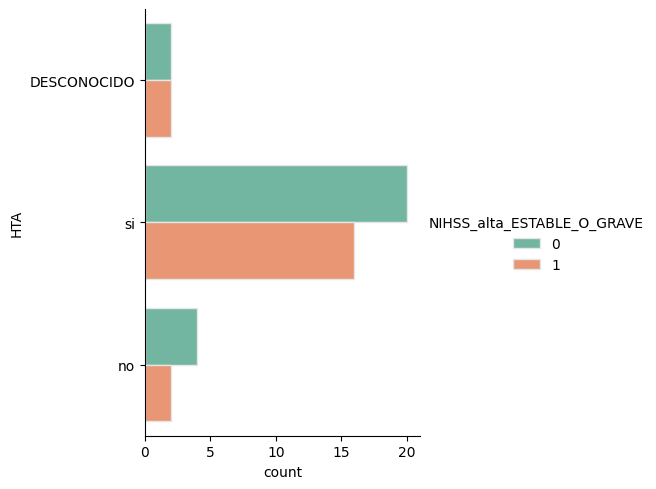

In [44]:
sns.catplot(y="HTA", hue="NIHSS_alta_ESTABLE_O_GRAVE", kind="count",
            palette="Set2", edgecolor=".9",
            data=dataset);

El grafico muestra que los pacientes que poseen hipertensión son muchos y su pronóstico es similar a que estado pueden tomar. 

## Binary Encoding (Codificación binaria)
Lo que hace este proceso es la transformación de variables de una columna a binario si es posible, esto solo aplica a las viables que tiene dos estados, si posee más estados no podrá aplicar(J. T. Hancock and T. M. Khoshgoftaar, “Survey on categorical data for neural networks").

In [45]:
binary_cols = [col for col in dataset.columns if dataset[col].dtype not in [int, float]
               and dataset[col].nunique() == 2]

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe


binary_cols

['INR_cat', 'COL. TOTAL_cat']

In [46]:
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler

for col in binary_cols:
    label_encoder(dataset, col)
    
dataset.head()

,HTA,DIABETES,EDAD,...,COL. TOTAL_cat,GLUCOSA_cat,EDAD_cat
0,DESCONOCIDO,DESCONOCIDO,53.0,...,0,Normal,Adulto
1,si,si,54.0,...,0,Normal,Adulto
2,si,si,78.0,...,0,Muy Alto,Anciano
3,si,si,87.0,...,0,Alto,Anciano
4,si,si,69.0,...,0,Alto,Anciano


## Label Encoding (Codificación de etiquetas)
Estas son variables ordinales, la codificación consiste en la traducción de ese orden en una enumeración, donde cada categoría es asociada con un número natural respetando el orden implícito existente entre categorías (J. T. Hancock and T. M. Khoshgoftaar, “Survey on categorical data for neural networks").

In [47]:
labelencoder = LabelEncoder()

In [48]:
dataset["NIHSS_alta_cat"] = labelencoder.fit_transform(dataset["NIHSS_alta_cat"])
dataset["GLASGOW_cat"] = labelencoder.fit_transform(dataset["GLASGOW_cat"])
dataset["CONTEO G.B._cat"] = labelencoder.fit_transform(dataset["CONTEO G.B._cat"])
dataset["TRIGLICERIDOS_cat"] = labelencoder.fit_transform(dataset["TRIGLICERIDOS_cat"])
dataset["GLUCOSA_cat"] = labelencoder.fit_transform(dataset["GLUCOSA_cat"])
dataset["EDAD_cat"] = labelencoder.fit_transform(dataset["EDAD_cat"])
dataset["HTA"] = labelencoder.fit_transform(dataset["HTA"])
dataset["DIABETES"] = labelencoder.fit_transform(dataset["DIABETES"])

dataset.head(5)

,HTA,DIABETES,EDAD,...,COL. TOTAL_cat,GLUCOSA_cat,EDAD_cat
0,0,0,53.0,...,0,3,0
1,2,2,54.0,...,0,3,0
2,2,2,78.0,...,0,2,2
3,2,2,87.0,...,0,0,2
4,2,2,69.0,...,0,0,2


**En las variables de Diabetes e Hipertensión el estado 2 representa "si" y el "no" es represnetado con un estado 1.**

## One-Hot Encoding:
Para las variables categóricas donde no existe tal relación ordinal, la codificación de enteros no es suficiente. De hecho, usar esta codificación y permitir que el modelo asuma un ordenamiento natural entre categorías puede dar como resultado un desempeño deficiente o resultados inesperados (predicciones a mitad de camino entre categorías) ( “Sparse matrix multiplication package (smmp),” ). En este caso, se puede aplicar una codificación one-hot a la representación de enteros. Aquí es donde se elimina la variable codificada entera y se agrega una nueva variable binaria para cada valor entero único. En el ejemplo de la variable " color ", hay 3 categorías y, por lo tanto, se necesitan 3 variables binarias. Se coloca un valor "1" en la variable binaria para el color y valores "0" para los otros colores.

In [49]:
# One Hot Encoding
dataset = pd.get_dummies(dataset)


# Como son muchas columnas, muestro todas
pd.options.display.max_columns = 0

dataset.head(5)

,HTA,DIABETES,EDAD,GLUCOSA,COL. TOTAL,TRIGLICERIDOS,INR,CONTEO G.B.,GLASGOW AL INICO ACV,NIHSS INICO ACV,NIHSS alta ACV,NIHSS_alta_cat,NIHSS_alta_ESTABLE_O_GRAVE,GLASGOW_cat,CONTEO G.B._cat,INR_cat,TRIGLICERIDOS_cat,COL. TOTAL_cat,GLUCOSA_cat,EDAD_cat,NIHSS_INICIO_cat_Déficit Importante,NIHSS_INICIO_cat_Déficit Mínimo,NIHSS_INICIO_cat_Grave,NIHSS_INICIO_cat_Leve (Trombolisando),NIHSS_INICIO_cat_Moderado (Buen Pronostico),NIHSS_INICIO_cat_Sin Déficit
0,0,0,53.0,137.090,268.0,130.0,1.08,41.9,11.0,14.0,42.0,2,1,2,0,1,2,0,3,0,0,0,0,0,1,0
1,2,2,54.0,119.995,187.0,130.0,1.09,8.3,15.0,6.0,0.0,5,0,1,2,1,2,0,3,0,0,0,0,0,1,0
2,2,2,78.0,359.420,159.0,97.0,0.89,8.5,15.0,5.0,2.0,3,0,1,2,1,2,0,2,2,0,0,0,1,0,0
3,2,2,87.0,186.200,193.0,133.0,0.90,7.0,15.0,1.0,0.0,5,0,1,2,1,2,0,0,2,0,1,0,0,0,0
4,2,2,69.0,170.000,184.0,137.0,1.28,12.1,15.0,3.0,2.0,3,0,1,0,1,2,0,0,2,0,0,0,1,0,0


# Análisis de datos de entrada
Ahora pasaremos al punto 3 de la metodología, veremos gráficos y datos que
interactuaran entre si. Nuestro interés por esta sección radica por la observación
de alguna tendencia de los datos. Crearemos dos dataset auxiliar, para observar los
datos que estaban y los que incorporamos en la seccion anterior.

In [50]:
# Mostramos las variables que posee la base de datos actualmente
columns_names = dataset.columns.values
print(columns_names)

['HTA' 'DIABETES' 'EDAD' 'GLUCOSA' 'COL. TOTAL' 'TRIGLICERIDOS' 'INR'
 'CONTEO G.B.' 'GLASGOW AL INICO ACV' 'NIHSS INICO ACV' 'NIHSS alta ACV'
 'NIHSS_alta_cat' 'NIHSS_alta_ESTABLE_O_GRAVE' 'GLASGOW_cat'
 'CONTEO G.B._cat' 'INR_cat' 'TRIGLICERIDOS_cat' 'COL. TOTAL_cat'
 'GLUCOSA_cat' 'EDAD_cat' 'NIHSS_INICIO_cat_Déficit Importante'
 'NIHSS_INICIO_cat_Déficit Mínimo' 'NIHSS_INICIO_cat_Grave'
 'NIHSS_INICIO_cat_Leve (Trombolisando)'
 'NIHSS_INICIO_cat_Moderado (Buen Pronostico)'
 'NIHSS_INICIO_cat_Sin Déficit']


In [51]:
# Variables originales
columnasOriginal = ['HTA', 'DIABETES', 'EDAD', 'GLUCOSA', 'COL. TOTAL', 'TRIGLICERIDOS', 'INR', 'CONTEO G.B.', 'GLASGOW AL INICO ACV', 'NIHSS INICO ACV', 'NIHSS alta ACV']
datasetOriginal = dataset[[*columnasOriginal]]

datasetOriginal.head(5)

,HTA,DIABETES,EDAD,GLUCOSA,COL. TOTAL,TRIGLICERIDOS,INR,CONTEO G.B.,GLASGOW AL INICO ACV,NIHSS INICO ACV,NIHSS alta ACV
0,0,0,53.0,137.090,268.0,130.0,1.08,41.9,11.0,14.0,42.0
1,2,2,54.0,119.995,187.0,130.0,1.09,8.3,15.0,6.0,0.0
2,2,2,78.0,359.420,159.0,97.0,0.89,8.5,15.0,5.0,2.0
3,2,2,87.0,186.200,193.0,133.0,0.90,7.0,15.0,1.0,0.0
4,2,2,69.0,170.000,184.0,137.0,1.28,12.1,15.0,3.0,2.0


In [52]:
# variables agregadas
columnasAgregadas = ['NIHSS_alta_cat', 'NIHSS_alta_ESTABLE_O_GRAVE', 'GLASGOW_cat',
 'CONTEO G.B._cat', 'INR_cat', 'TRIGLICERIDOS_cat', 'COL. TOTAL_cat',
 'GLUCOSA_cat', 'EDAD_cat', 'NIHSS_INICIO_cat_Déficit Importante',
 'NIHSS_INICIO_cat_Déficit Mínimo', 'NIHSS_INICIO_cat_Grave',
 'NIHSS_INICIO_cat_Leve (Trombolisando)',
 'NIHSS_INICIO_cat_Moderado (Buen Pronostico)',
 'NIHSS_INICIO_cat_Sin Déficit']
datasetAgregado = dataset[[*columnasAgregadas]]

datasetAgregado.head(5)

,NIHSS_alta_cat,NIHSS_alta_ESTABLE_O_GRAVE,GLASGOW_cat,CONTEO G.B._cat,INR_cat,TRIGLICERIDOS_cat,COL. TOTAL_cat,GLUCOSA_cat,EDAD_cat,NIHSS_INICIO_cat_Déficit Importante,NIHSS_INICIO_cat_Déficit Mínimo,NIHSS_INICIO_cat_Grave,NIHSS_INICIO_cat_Leve (Trombolisando),NIHSS_INICIO_cat_Moderado (Buen Pronostico),NIHSS_INICIO_cat_Sin Déficit
0,2,1,2,0,1,2,0,3,0,0,0,0,0,1,0
1,5,0,1,2,1,2,0,3,0,0,0,0,0,1,0
2,3,0,1,2,1,2,0,2,2,0,0,0,1,0,0
3,5,0,1,2,1,2,0,0,2,0,1,0,0,0,0
4,3,0,1,0,1,2,0,0,2,0,0,0,1,0,0


Se observa que ambos dataset tienen un numero de cantidades de variables similares y que la última posee datos más cercanos a lo binario.

## Análisis de densidad y estimación por variable
La densidad de los datos nos da la probabilidad de que una variable tomé un valor determinado por su densidad. La importancia de la densidad radica en comprender en que valores los datos están siendo más remanentes.

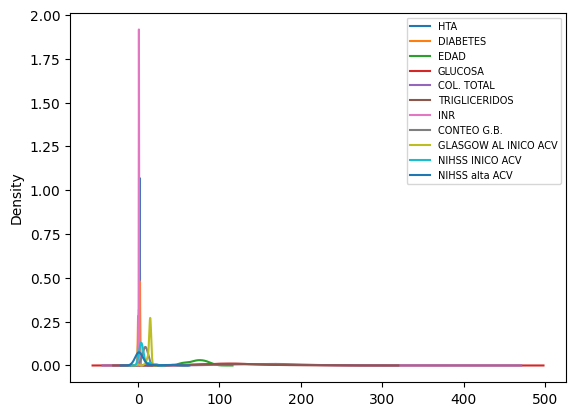

In [53]:
# Análisis de densidad y estimación en los datos originales
plt.rc('legend', fontsize=7)
datasetOriginal.plot.density();

Como los datos son variados numéricamente, en el grafico no se alcanza a reflejar cada variable. Si fuera necesario deberíamos analizar en este caso cada variable por separado, siendo que este no es el caso para la mayoría de las variables. A continuación, se mostrará el grafico de densidad de los exámenes.

C:\Users\Abraham\AppData\Local\Temp\ipykernel_4276\2094315797.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset['EDAD'], bins=30, color='darkred', ax=axes[0, 0])
C:\Users\Abraham\AppData\Local\Temp\ipykernel_4276\2094315797.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset['G

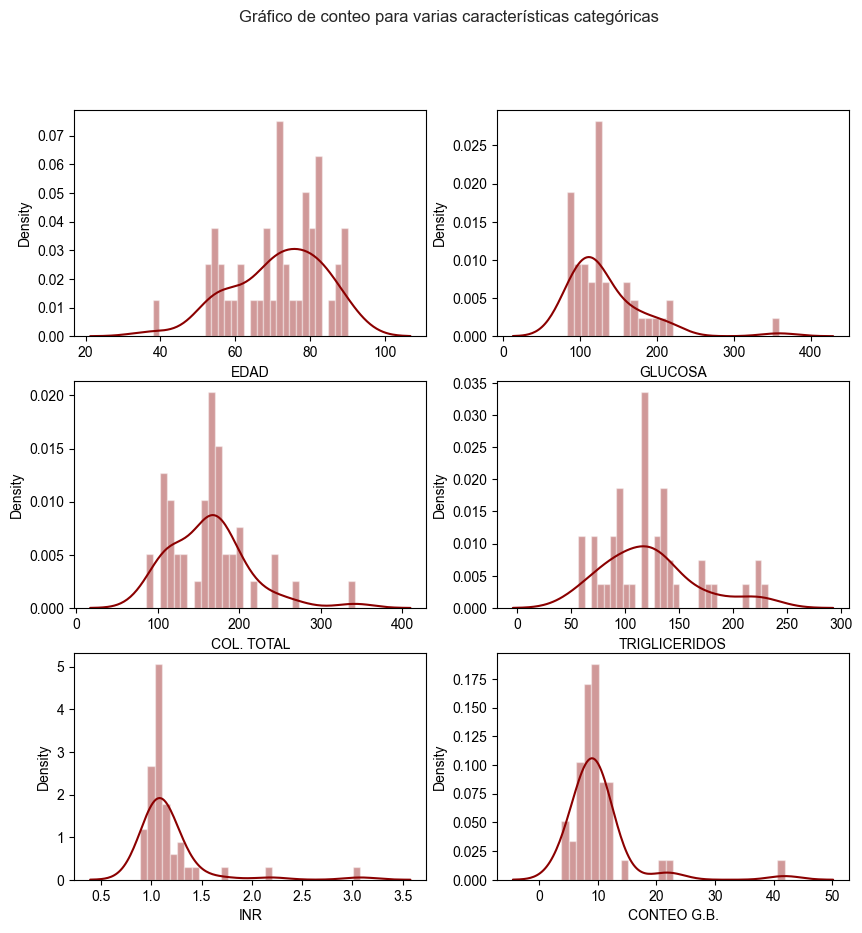

In [54]:
fig,axes = plt.subplots(3, 2, figsize = (10, 10))
sns.set_style('darkgrid')
fig.suptitle("Gráfico de conteo para varias características categóricas")

# Variables muy dispersas
sns.distplot(dataset['EDAD'], bins=30, color='darkred', ax=axes[0, 0])
sns.distplot(dataset['GLUCOSA'], bins=30, color='darkred', ax=axes[0, 1])
sns.distplot(dataset['COL. TOTAL'], bins=30, color='darkred', ax=axes[1, 0])
sns.distplot(dataset['TRIGLICERIDOS'], bins=30, color='darkred', ax=axes[1, 1])
sns.distplot(dataset['INR'], bins=30, color='darkred', ax=axes[2, 0])
sns.distplot(dataset['CONTEO G.B.'], bins=30, color='darkred', ax=axes[2, 1])

plt.show();

Las tendencias de los gráficos están orientadas al grupo etario entre los 60 y 80 años  estos que poseen una densidad en los datos alta, es decir que los exámenes se encuentran semejantes a los datos.

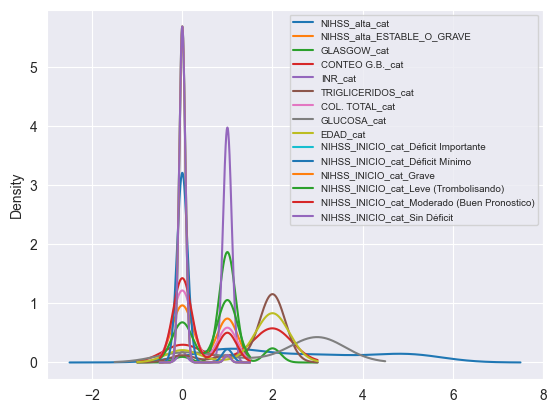

In [55]:
# Análisis de densidad y estimación en los datos agregados
plt.rc('legend', fontsize=7)
datasetAgregado.plot.density();

Se puede interpretar el grafico de la siguiente forma: En la variable “NIHSS_INICIO_cat_Sin Déficit” la densidad de los datos es alta en el valor 0, entendiendo que esta poseía solo dos estados, 0 para confirmar que no está presente el valor y 1 para confirmar que está presente. Si lo traducimos a palabras normales, los pacientes sin déficit al principio medidos por la escala son muy pocos, la mayoría presenta déficit. El análisis individual no es necesario en este caso, ya que los valores están bien detallados a la vista, aunque estos son los valores importantes que dejo el procesado de datos de entrada.

## Análisis por conteo de variables categóricas
Para demostrar la cantidad de datos presente en algunas de las variables originales que son más agrupables se representará con escalas de contador por categoría. 

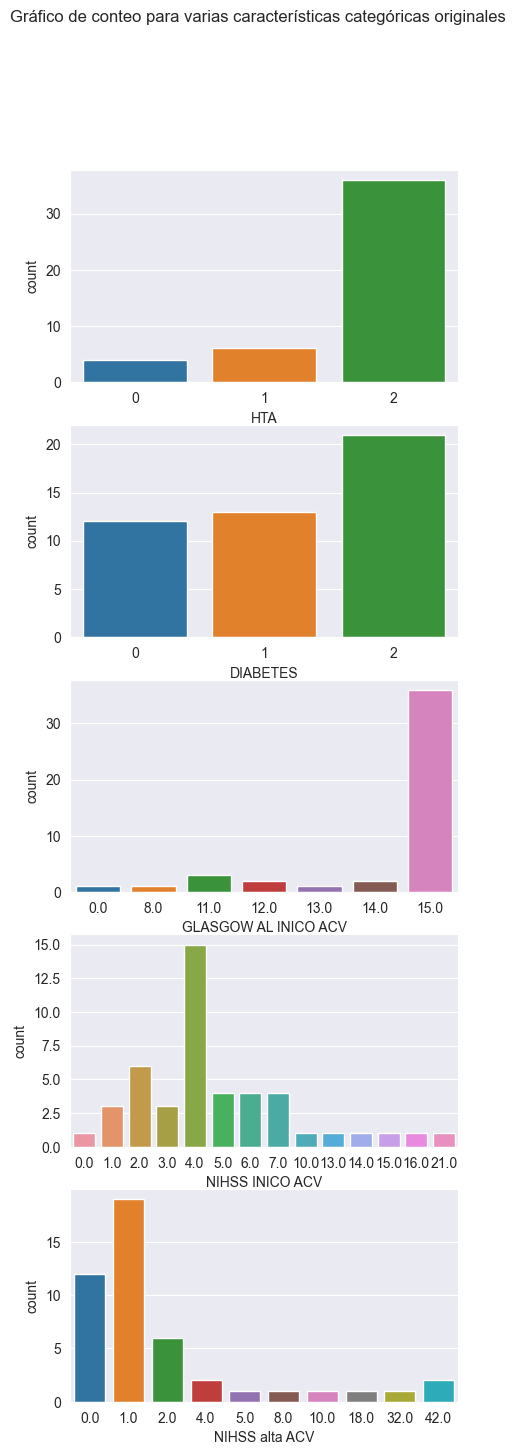

In [56]:
fig,axes = plt.subplots(5, figsize = (5, 16))
sns.set_style('darkgrid')
fig.suptitle("Gráfico de conteo para varias características categóricas originales")

sns.countplot(ax=axes[0],data=dataset,x='HTA')
sns.countplot(ax=axes[1],data=dataset,x='DIABETES')
sns.countplot(ax=axes[2],data=dataset,x='GLASGOW AL INICO ACV')
sns.countplot(ax=axes[3],data=dataset,x='NIHSS INICO ACV')
sns.countplot(ax=axes[4],data=dataset,x='NIHSS alta ACV')

plt.show()

Las tasas de conteo de los pacientes indican una tendencia en algunos valores específicos, donde a simple vista en las escalas se encuentran en buen estado, pero la gran mayoría contiene enfermedades categóricas no transmisibles.

## Distibución de Diabetes e Hipertensión
Las variables de Hipertensión y Diabetes ya poseian un valor binario como resultado, en este caso tiene un tercer valor que es el de desconocido por que son datos que no se pueden predecir.

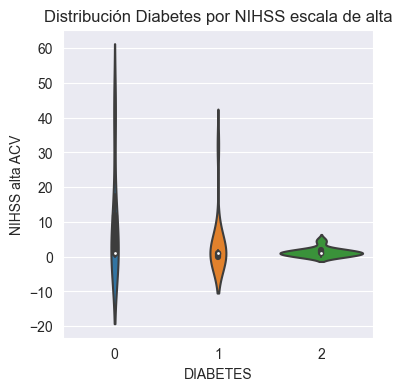

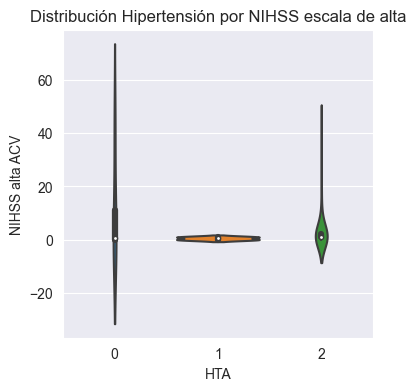

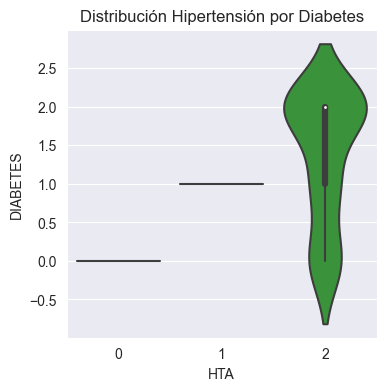

In [57]:
fig, ax = plt.subplots(figsize=(4, 4))

sns.violinplot(
        x     = 'DIABETES',
        y     = 'NIHSS alta ACV',
        data  = dataset,
        #color = "white",
        ax    = ax
    )

ax.set_title('Distribución Diabetes por NIHSS escala de alta');

fig, ax2 = plt.subplots(figsize=(4, 4))

sns.violinplot(
        x     = 'HTA',
        y     = 'NIHSS alta ACV',
        data  = dataset,
        #color = "white",
        ax    = ax2
    )

ax2.set_title('Distribución Hipertensión por NIHSS escala de alta');

fig, ax2 = plt.subplots(figsize=(4, 4))

sns.violinplot(
        x     = 'HTA',
        y     = 'DIABETES',
        data  = dataset,
        #color = "white",
        ax    = ax2
    )

ax2.set_title('Distribución Hipertensión por Diabetes');

La distribución de la Diabetes e Hipertensión es inversa en la escala de alta de los pacientes. El grafico muestra que en su mayoría los pacientes que poseen diabetes tienen un pronostico al alta más favorable, en cambio los que poseen hipertensión tienen un pronóstico menos favorable. Sin embargo, la distribución de pacientes es muy pronunciada hacía que los pacientes poseen las dos enfermedades en conjunto.

## Mapa de calor de variables
Los mapas de calor pueden ayudar a visualizar el impacto de muchas categorías en los valores y son una excelente opción para ver detalles cuando se trabaja con conjuntos de datos más grandes. Los mapas de calor utilizan una variedad de colores fríos y cálidos para ayudarnos a comprender qué elementos de datos generan más interés (áreas calientes) y qué elementos se ignoran (áreas frías).

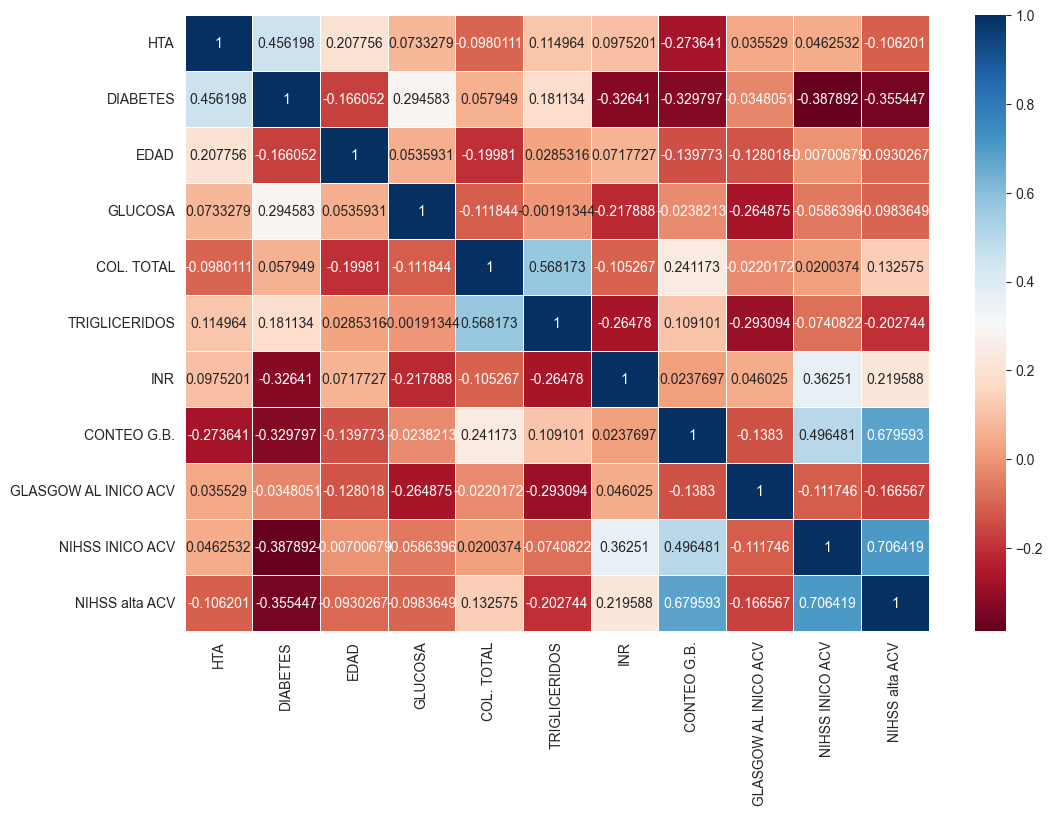

In [58]:
fig = plt.figure(figsize=(12,8))
corr = datasetOriginal.corr()
ax = sns.heatmap(corr, linewidths=.5, cmap="RdBu", annot=True, fmt="g")

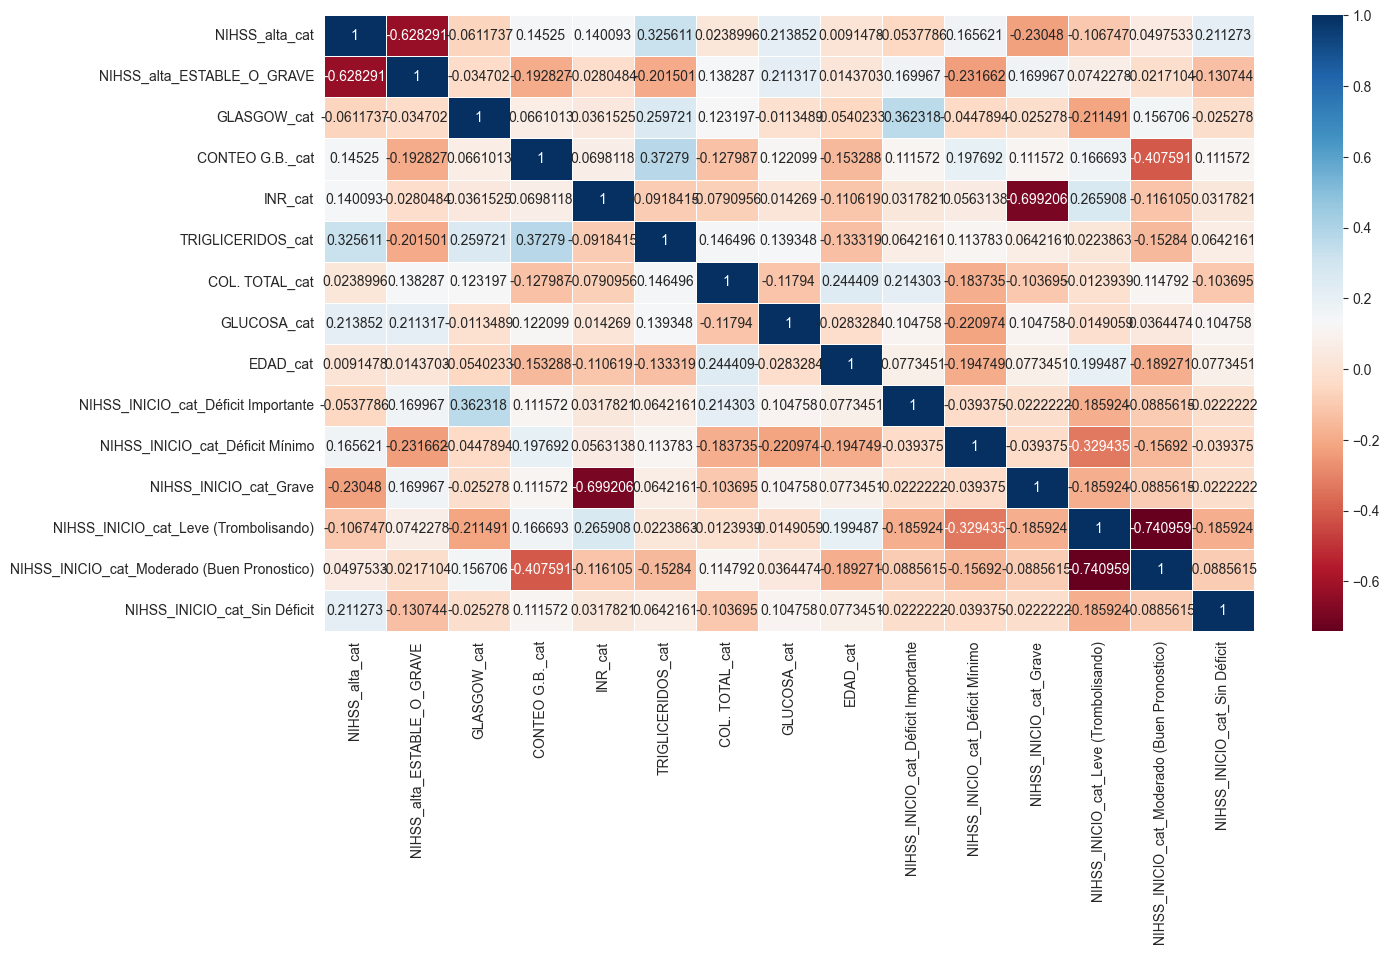

In [59]:
fig = plt.figure(figsize=(15,8))
corr = datasetAgregado.corr()
ax = sns.heatmap(corr, linewidths=.5, cmap="RdBu", annot=True, fmt="g")

El primer dataset muestra un alto interés en casi todas las variables tendiendo al rojizo y algunos sectores fríos, en cambio el segundo dataset presenta variables más estables con estados más cercanos a la neutralidad.

# Modelo de Machine Learning

<h1 align='center'>  Bosque Aleatorio </h1> 
<h2 align='center'>  Clasificación </h2> 

# Random Forest - Entrenamiento del algoritmo
Un modelo de bosque aleatorio consta de un conjunto de árboles de decisión individuales, cada uno de los cuales se entrena mediante un procedimiento de arranque para seleccionar aleatoriamente muestras de los datos de entrenamiento originales. Esto significa que cada árbol se entrena con datos ligeramente diferentes. En cada árbol individual, las observaciones se propagan a través de bifurcaciones (nodos) que generan la estructura del árbol hasta llegar a un nodo terminal(libro).

En el entrenamiento del algoritmo el programa de Machine Learning adquiere la información que trabajamos en los métodos anteriores. Es aquí donde se obtendrá el conocimiento para futuras decisiones, es importante asegurarse que las decisiones que sean tomadas posteriormente al proceso de entrenamiento se añadan a la base de conocimiento del algoritmo para futuras ejecuciones de este.

La BDD trabajada actualmente cuenta con: 

In [60]:
print('Existen {} pacientes con {} variables.'.format(*dataset.shape))
print("Existen", dataset.size, "elementos")

Existen 46 pacientes con 26 variables.
Existen 1196 elementos


## Variable categórica
En el paso de la preparación de los datos de entrada, propusimos la variable “NIHSS alta ACV” que podía poseer 42 valores diferentes, la cual se clasificó y se transformó en “NIHSS_alta_cat” que contenía 6 categorías las que fueron reducidas a 1 variable con dos estados. Asi el paciente tendrá un buen pronóstico o no con el nombre de la variable “NIHSS_alta_ESTABLE_O_GRAVE”. 
Los estudios de Machine Learning no sugieren tener variables binarias para nuestro estudio.

Las variables dependientes representan el rendimiento o conclusión que se está estudiando. Las variables independientes, además conocidas en una relación estadística como regresores, representan insumos o causas, donde se encuentran las razones potenciales de alteración.

In [61]:
# variables objetivo e independientes:
from sklearn.model_selection import train_test_split

# X son nuestras variables independientes
X = dataset.drop('NIHSS_alta_ESTABLE_O_GRAVE', axis = 1)

# y es nuestra variable dependiente
y = dataset['NIHSS_alta_ESTABLE_O_GRAVE']

# Uso de Skicit-learn para dividir datos en conjuntos de entrenamiento y prueba 
# División 75% de datos para entrenamiento, 25% de datos para test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

## Creación del modelo y entrenamiento
Para la creación del modelo se utilizará el modelo en la forma más estándar posible, siendo que los modelos, antes del entrenamiento, pueden recibir ajustes para manejar los datos de entrada, de una forma u otra. Para que sea lo más parejo posible entre modelos se dejará de forma estándar.

In [62]:
from sklearn.ensemble import RandomForestClassifier

# Creamos el modelo de Bosque Aleatorio (y configuramos el número máximo de nodos-hoja)
rfc = RandomForestClassifier(criterion = 'gini', random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

### Estructura del árbol creado

In [63]:
# Lista de características para uso posterior
features = dataset.drop('NIHSS_alta_ESTABLE_O_GRAVE', axis = 1)
feature_list = list(features.columns)

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rfc.estimators_[5]
print('The depth of this tree is:', tree.tree_.max_depth)

# Export the image to a dot file
export_graphviz(tree, out_file = 'randomForestClassification.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('randomForestClassification.dot')

# Write graph to a png file
graph.write_png('randomForestClassification.png'); 

The depth of this tree is: 3


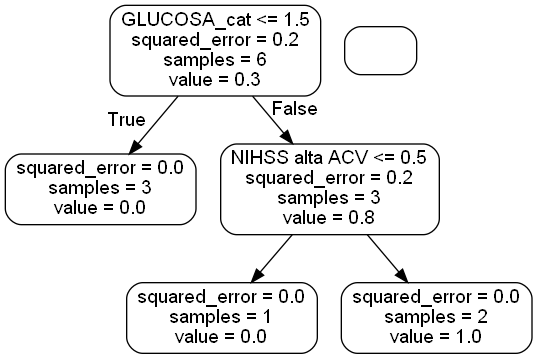

## Predicciones sobre los datos de prueba y métricas de rendimiento
Para llevar una forma más ordenada, es necesario crear las variables de predicciones, para asi sacar las métricas de rendimiento más fácilmente. Las métricas de rendimiento nos ofrecerán información de cómo se comportó el algoritmo durante el entrenamiento, dando a conocer valores importantes como lo son la precisión, exhaustividad, valor-F.

In [64]:
# Predicción Entrenamiento 
prediccionEntreno = rfc.predict(X_train)

# Predicción Tests
prediccionTests = rfc.predict(X_test)

In [65]:
from sklearn import metrics

print("Entrenamiento - Presición :", metrics.accuracy_score(y_train, prediccionEntreno))
print("Entrenamiento - Reporte de clasificación:\n", metrics.classification_report(y_train, prediccionEntreno))

Entrenamiento - Presición : 1.0
Entrenamiento - Reporte de clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



La precisión de los datos de entrenamiento en el modelo tiene un valor excelente de 100% de predicción, la exhaustividad informa la cantidad de datos capaz de identificar y en este caso es de un 100% de los datos y finalmente el F1 combina los valores de precisión y exhaustividad obteniéndose un 100% igual. Todos los valores mencionados aplican para los estados de la variable predictora.

## Matriz de Confusión

En el campo de la inteligencia artificial y en especial en el problema de la clasificación estadística, una matriz de confusión es una herramienta que permite la visualización del desempeño de un algoritmo que se emplea en aprendizaje supervisado.

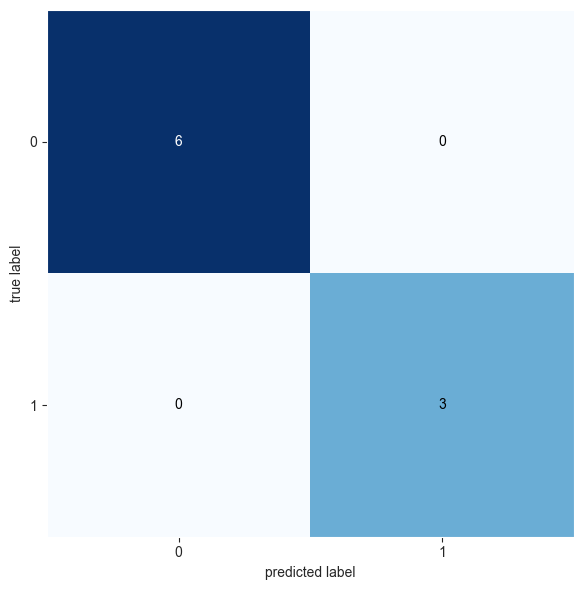

In [66]:
from matplotlib import pyplot as plot
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

matriz = confusion_matrix(y_train, prediccionEntreno)

plot_confusion_matrix(conf_mat=matriz, figsize=(6,6), show_normed=False)
plot.tight_layout()

En la matriz de confusión (1, 1) podemos observar el resultado en el que el modelo predice correctamente la clase positiva y en el (2, 2) el resultado donde el modelo predice correctamente la clase negativa. Los demás elementos de la matriz contienen valor nulo o 0, estos son los errores de la predicción.

# Random Forest - Testeo del algoritmo
El testing tiene la finalidad de llevar a cabo la prueba si el modelo funciona correctamente, identificando riesgos o erros que se produjeron en los datos. No se realizará ajustes posteriores al testing para poder comparar los algoritmos en la sección de resultados.

## Predicciones sobre los datos del testing y métricas de rendimiento
Ahora es momento de evaluar los datos ya entrenados con el testing. Las métricas de rendimiento nos ofrecerán información de cómo se comportó el algoritmo durante el entrenamiento, dando a conocer valores importantes como lo son la precisión, exhaustividad, valor-F.

In [67]:
print("Tests - Presición :", metrics.accuracy_score(y_test, prediccionTests))
print("Tests - Reporte de clasificación:\n", metrics.classification_report(y_test, prediccionTests))

Tests - Presición : 0.6216216216216216
Tests - Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.61      0.85      0.71        20
           1       0.67      0.35      0.46        17

    accuracy                           0.62        37
   macro avg       0.64      0.60      0.58        37
weighted avg       0.63      0.62      0.59        37



La precisión de los datos del testing en el modelo tiene un valor de 61% de predicción para el estado 0 y un 67% de predicción para el estado 1. La exhaustividad en el estado 0 alcanza el 85% de los datos y en el estado 1 alcanza solo el 35%.  Por otra parte, el F1 combina los valores de precisión y exhaustividad obteniéndose un 71% en el estado 0 y un 46% en el estado 1. 

Lo que se busca es la precisión del modelo, por consecuencia, el Algoritmo de Machine Learning Random Forest tiene una precisión del 62,1% de predicción.

## Matriz de Confusión
Evaluaremos la matriz de confusión que se elaboró con los datos del testing.

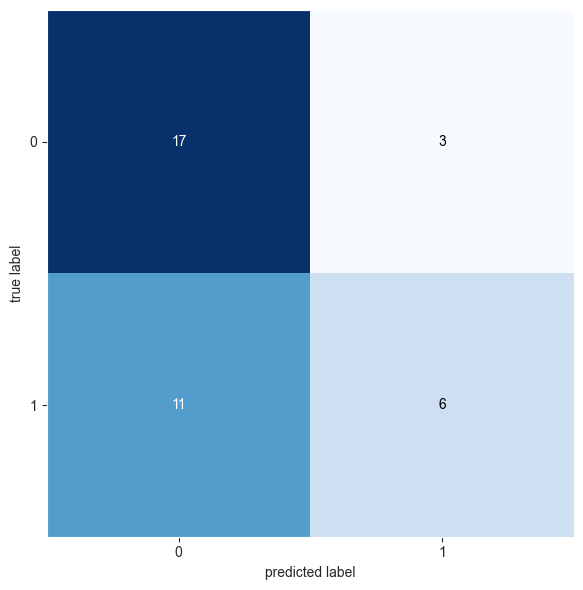

In [68]:
matriz = confusion_matrix(y_test, prediccionTests)

plot_confusion_matrix(conf_mat=matriz, figsize=(6,6), show_normed=False)
plt.tight_layout()

En la matriz de confusión (1, 1) podemos observar el resultado en el que el modelo predice correctamente la clase positiva con un alto valor y en el (2, 2) el resultado donde el modelo predice correctamente la clase negativa también con un alto valor, acercándose a la misma de la clase positiva. Los demás elementos de la matriz contienen valor pequeño, estos son los errores de la predicción. 

Las afirmaciones anteriores sugieren que la las predicciones son altas, pero también existen errores en la predicción.

## Importancia de los predictores
Por experiencia previa y contemplando los gráficos producidos en el paso 3, sabemos que algunas características no son útiles para nuestro problema de predicción. Reducir la cantidad de funciones será la mejor alternativa, lo que acotará el tiempo de ejecución, con suerte sin comprometer significativamente el rendimiento, asi podemos examinar la importancia de las funciones de nuestro modelo. La importancia de cada predictor en el modelo se calcula como la reducción total (normalizada) en el criterio de división. Si un predictor no ha sido seleccionado en ninguna división, no se ha incluido en el modelo y por lo tanto su importancia es 0.

In [69]:
# Predicciones probabilísticas
# ===============================
# Con .predict_proba() se obtiene, para cada observación, la probabilidad predicha
# de pertenecer a cada una de las dos clases.
predicciones = rfc.predict_proba(X_test)
predicciones = pd.DataFrame(predicciones, columns = rfc.classes_)
predicciones

,0,1
0,0.64,0.36
1,0.74,0.26
2,0.76,0.24
3,0.74,0.26
4,0.57,0.43
5,0.62,0.38
6,0.52,0.48
7,0.65,0.35
8,0.46,0.54
9,0.32,0.68


Este método acepta un solo argumento que corresponde a los datos sobre los cuales se calculan las probabilidades y devuelve una matriz de listas que contienen las probabilidades de clase para los puntos de datos de entrada. En este caso particular podemos observar que los estados de la variable predictora tienen un valor de porcentaje predictor, por ejemplo, la tupla 0 posee un 64% y fracción de precisión para el estado 0 y un 0,36% y fracción para el estado 1.

En síntesis se observa que cada uno de las variables reaccionan y toma valores porcentuales a que estado del predictor pertenece.

In [70]:
# Predicciones con clasificación final
# ==============================================================================
# Con .predict() se obtiene, para cada observación, la clasificación predicha por
# el modelo. Esta clasificación se corresponde con la clase con mayor probabilidad.
predicciones = rfc.predict(X_test)
predicciones = pd.DataFrame(predicciones)
predicciones

,0
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,1
9,1


Se observa un valor binario de 0 o 1, donde se muestra cada variable desarrollada en el modelo puede tomar dicho valor. El valor 0 demuestra que la tupla no logra predecir el estado 0 de la variable predictora, y por el contrario, el estado 1 es que logra la predicción del estado en esa tupla.

In [71]:
importancia_predictores = pd.DataFrame(
                            {'Predictor': dataset.drop(columns = "NIHSS_alta_ESTABLE_O_GRAVE").columns,
                             'importancia': rfc.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,Predictor,importancia
5,TRIGLICERIDOS,0.149579
2,EDAD,0.098917
9,NIHSS INICO ACV,0.087893
4,COL. TOTAL,0.079422
3,GLUCOSA,0.076047
17,GLUCOSA_cat,0.063920
16,COL. TOTAL_cat,0.060227
10,NIHSS alta ACV,0.056171
6,INR,0.054726
7,CONTEO G.B.,0.052931


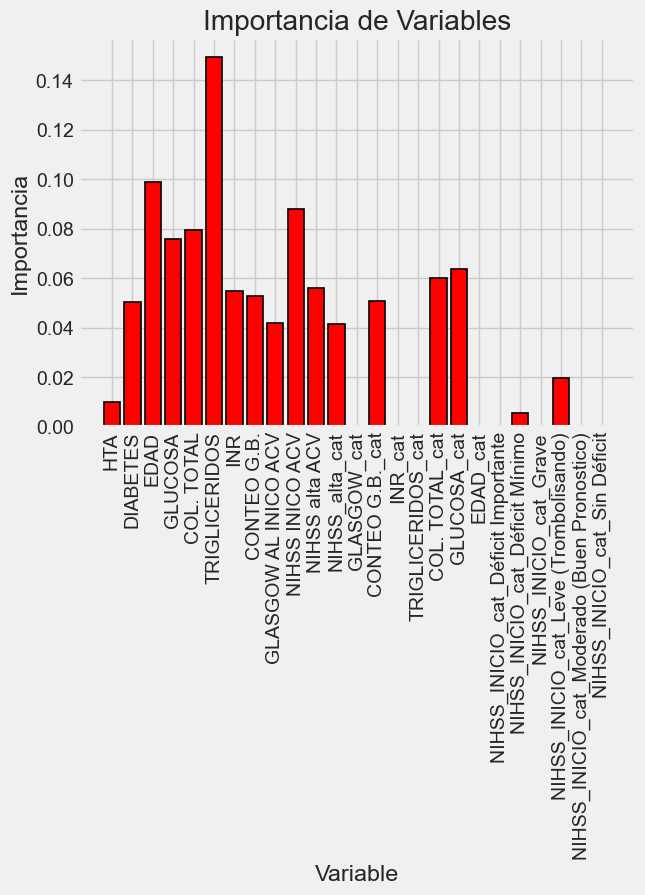

In [72]:
# Get numerical feature importances
importances = list(rfc.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Reset style 
plt.style.use('fivethirtyeight')

# lista de x ubicaciones para trazar
x_values = list(range(len(importances)))

# Gráfico de barras
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Marque las etiquetas para el eje x
plt.xticks(x_values, feature_list, rotation='vertical')

# Etiquetas de eje y título
plt.ylabel('Importancia'); plt.xlabel('Variable'); plt.title('Importancia de Variables');

El cálculo de importancia muestra que existen muchas variables con importancia al momento de la predicción, siendo la que destaca “TRIGLICERIDOS” con un 14,9% de importancia. Viendo el grafico, se observa que aún hay variables que no son significantes.

## Importancia acumulada
Ahora reduciremos la cantidad de funciones en uso por el modelo a solo aquellas requeridas para representar el 95% de la importancia. Se debe usar el mismo número de características en los conjuntos de entrenamiento y prueba.

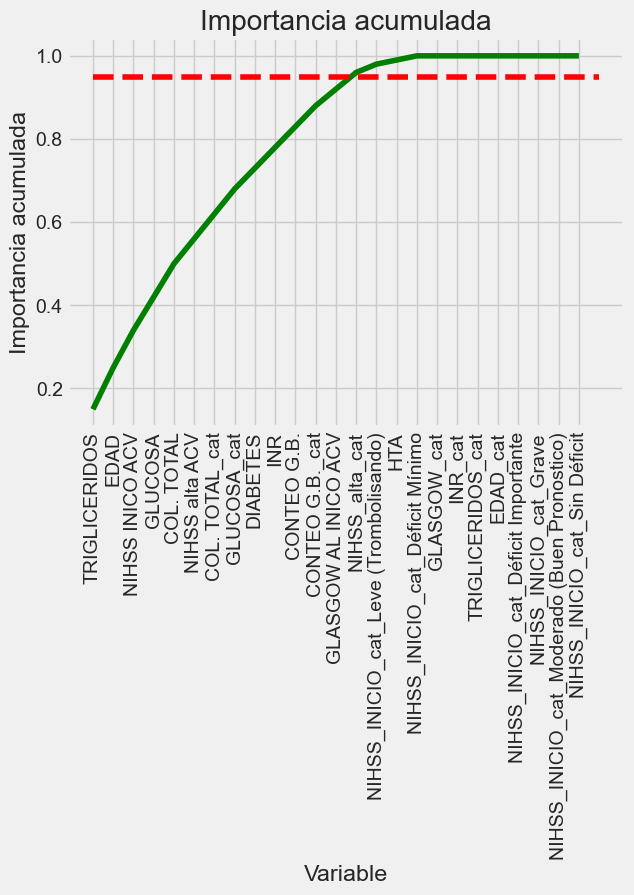

In [73]:
# Lista de funciones ordenadas de mayor a menor importancia
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Importancias acumulativas
cumulative_importances = np.cumsum(sorted_importances)

# Haz un gráfico de líneas
plt.plot(x_values, cumulative_importances, 'g-')

# Dibujar línea al 95% de importancia retenida
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Formato x ticks y etiquetas
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Etiquetas de eje y título
plt.xlabel('Variable'); plt.ylabel('Importancia acumulada'); plt.title('Importancia acumulada');

In [74]:
# Encuentre el número de características para una importancia acumulada del 95%
# Agregue 1 porque Python está indexado a cero
print('Número de columna para el 95 % de importancia:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Número de columna para el 95 % de importancia: 14


En el gráfico de importancia acumulada la curva se dispara con la “GLASGOW AL INICO ACV” y se ratifica con el resultado del 95% de importancia medido anteriormente con el valor cercano del 95% de importancia acumulada de los datos.

# Modelo de Machine Learning

<h1 align='center'>  Bosque Aleatorio </h1> 
<h2 align='center'>  Regresión </h2> 

# 5-. Entrenar el modelo en los datos de entrenamiento

In [75]:
# variables objetivo e independientes:
from sklearn.model_selection import train_test_split

# X son nuestras variables independientes
X = dataset.drop('NIHSS_alta_ESTABLE_O_GRAVE', axis = 1)

# y es nuestra variable dependiente
y = dataset['NIHSS_alta_ESTABLE_O_GRAVE']

# Uso de Skicit-learn para dividir datos en conjuntos de entrenamiento y prueba 
# División 75% de datos para entrenamiento, 25% de datos para test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

## Creamos el modelo y entrenamos

In [76]:
from sklearn.ensemble import RandomForestRegressor

# Creamos el modelo de Bosque Aleatorio (y configuramos el número máximo de nodos-hoja)
rfr = RandomForestRegressor(max_depth = 5, random_state=0)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, random_state=0)

### Estructura del árbol creado

In [77]:
print('The depth of this tree is:', tree.tree_.max_depth)

The depth of this tree is: 3


In [78]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rfr.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'randomForestRegression.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('randomForestRegression.dot')

# Write graph to a png file
graph.write_png('randomForestRegression.png'); 

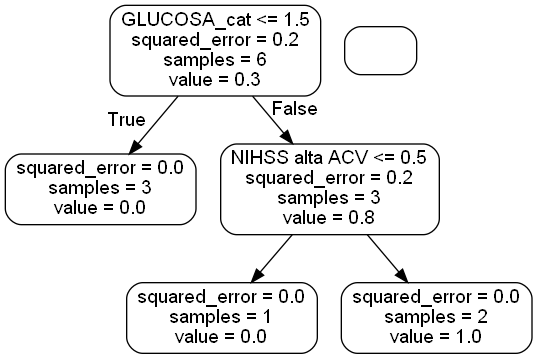

# 6-. Predicciones sobre los datos de prueba
Se evalúa la capacidad predictiva del árbol inicial calculando el accuracy en el conjunto de test.

In [79]:
# Predicción Entrenamiento 
prediccionEntreno = rfr.predict(X_train)

# Predicción Tests
prediccionTests = rfr.predict(X_test)

# Fase de Entrenamiento

In [80]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

# Función de puntuación de regresión de varianza explicada.
print("Entrenamiento - Varianza :", explained_variance_score(y_train, prediccionEntreno))
print("Entrenamiento - Error Absoluto :", mean_absolute_error(y_train, prediccionEntreno))

Entrenamiento - Varianza : 0.8060999999999999
Entrenamiento - Error Absoluto : 0.1922222222222222


In [81]:
from sklearn import metrics

# Aqui nos arroja resultados inválidos, ya que es una técnica de regresión y nos da resultados ya que en las de regresión son números de predicción
print("Entrenamiento - Presición :", metrics.accuracy_score(y_train, prediccionEntreno.round(), normalize=False))
print("Entrenamiento - Reporte de clasificación:\n", metrics.classification_report(y_train, prediccionEntreno.round()))

Entrenamiento - Presición : 9
Entrenamiento - Reporte de clasificación:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         6
           1       1.00      1.00      1.00         3

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



# 7-. Comparar las predicciones con los objetivos conocidos del conjunto de pruebas y calcule las métricas de rendimiento
Una vez entrenado el modelo, se pueden predecir nuevas observaciones.

# Fase de validación (Usando datos de Test)

In [82]:
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

# Función de puntuación de regresión de varianza explicada.
print("Entrenamiento - Varianza :", explained_variance_score(y_test, prediccionTests))
print("Entrenamiento - Error Absoluto :", mean_absolute_error(y_test, prediccionTests))

Entrenamiento - Varianza : 0.2733547058823532
Entrenamiento - Error Absoluto : 0.40378378378378377


In [83]:
# Aqui nos arroja resultados inválidos, ya que es una técnica de regresión y nos da resultados ya que en las de regresión son números de predicción
print("Entrenamiento - Presición :", metrics.accuracy_score(y_test, prediccionTests.round(), normalize=False))
print("Entrenamiento - Reporte de clasificación:\n", metrics.classification_report(y_test, prediccionTests.round()))

Entrenamiento - Presición : 27
Entrenamiento - Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.68      0.95      0.79        20
           1       0.89      0.47      0.62        17

    accuracy                           0.73        37
   macro avg       0.78      0.71      0.70        37
weighted avg       0.78      0.73      0.71        37



# 8-. Importancia de los predictores
Por experiencia previa y los gráficos producidos al principio, sabemos que algunas características no son útiles para nuestro problema de predicción. Para reducir la cantidad de funciones, lo que reducirá el tiempo de ejecución, con suerte sin reducir significativamente el rendimiento, podemos examinar la importancia de las funciones del Arbol de Decisión.

## Interpretación el modelo, reporte los resultados visual y numéricamente

La importancia de cada predictor en modelo se calcula como la reducción total (normalizada) en el criterio de división, en este caso el índice Gini, que consigue el predictor en las divisiones en las que participa. Si un predictor no ha sido seleccionado en ninguna divisón, no se ha incluido en el modelo y por lo tanto su importancia es 0.

In [84]:
# Predicciones con clasificación final
# ==============================================================================
# Con .predict() se obtiene, para cada observación, la clasificación predicha por
# el modelo. Esta clasificación se corresponde con la clase con mayor probabilidad.
predicciones = rfr.predict(X = X_test)
predicciones

array([0.31, 0.26, 0.24, 0.17, 0.49, 0.4 , 0.52, 0.4 , 0.55, 0.71, 0.3 ,
       0.22, 0.21, 0.35, 0.28, 0.25, 0.42, 0.71, 0.69, 0.5 , 0.26, 0.43,
       0.32, 0.39, 0.35, 0.55, 0.6 , 0.58, 0.42, 0.49, 0.27, 0.46, 0.24,
       0.39, 0.5 , 0.4 , 0.61])

In [85]:
importancia_predictores = pd.DataFrame(
                            {'Predictor': dataset.drop(columns = "NIHSS_alta_ESTABLE_O_GRAVE").columns,
                             'importancia': rfr.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


,Predictor,importancia
5,TRIGLICERIDOS,0.179683
2,EDAD,0.099026
11,NIHSS_alta_cat,0.098362
9,NIHSS INICO ACV,0.096681
17,GLUCOSA_cat,0.085693
3,GLUCOSA,0.072092
1,DIABETES,0.068903
4,COL. TOTAL,0.055873
6,INR,0.050415
7,CONTEO G.B.,0.044192


In [86]:
# Lista de características para uso posterior
features = dataset.drop('NIHSS_alta_ESTABLE_O_GRAVE', axis = 1)
feature_list = list(features.columns)

# Get numerical feature importances
importances = list(rfr.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: TRIGLICERIDOS        Importance: 0.18
Variable: EDAD                 Importance: 0.1
Variable: NIHSS INICO ACV      Importance: 0.1
Variable: NIHSS_alta_cat       Importance: 0.1
Variable: GLUCOSA_cat          Importance: 0.09
Variable: DIABETES             Importance: 0.07
Variable: GLUCOSA              Importance: 0.07
Variable: COL. TOTAL           Importance: 0.06
Variable: INR                  Importance: 0.05
Variable: CONTEO G.B.          Importance: 0.04
Variable: COL. TOTAL_cat       Importance: 0.04
Variable: GLASGOW AL INICO ACV Importance: 0.03
Variable: NIHSS alta ACV       Importance: 0.03
Variable: CONTEO G.B._cat      Importance: 0.03
Variable: HTA                  Importance: 0.01
Variable: GLASGOW_cat          Importance: 0.0
Variable: INR_cat              Importance: 0.0
Variable: TRIGLICERIDOS_cat    Importance: 0.0
Variable: EDAD_cat             Importance: 0.0
Variable: NIHSS_INICIO_cat_Déficit Importante Importance: 0.0
Variable: NIHSS_INICIO_cat_Défici

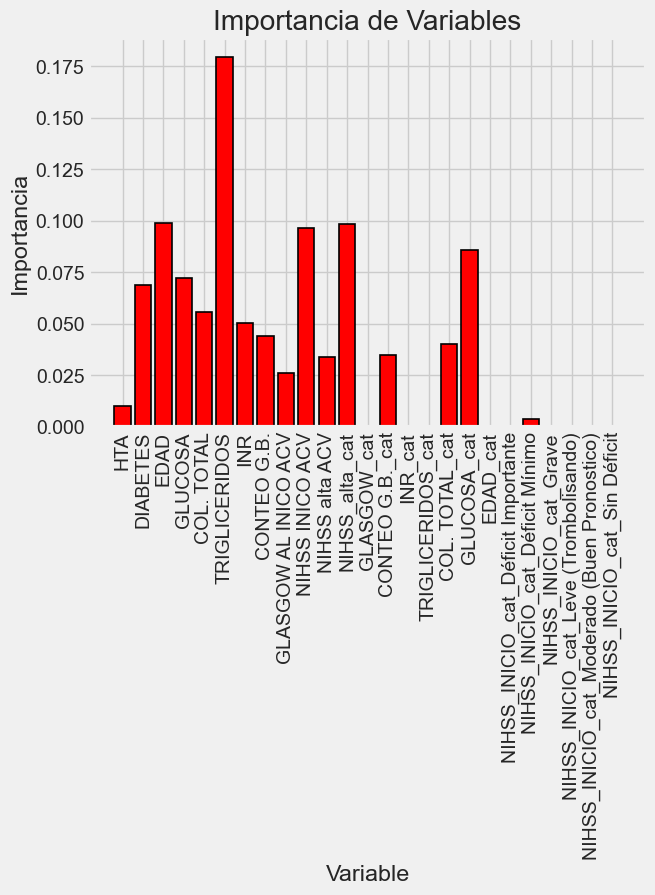

In [87]:
# Reset style 
plt.style.use('fivethirtyeight')

# lista de x ubicaciones para trazar
x_values = list(range(len(importances)))

# Gráfico de barras
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Marque las etiquetas para el eje x
plt.xticks(x_values, feature_list, rotation='vertical')

# Etiquetas de eje y título
plt.ylabel('Importancia'); plt.xlabel('Variable'); plt.title('Importancia de Variables');

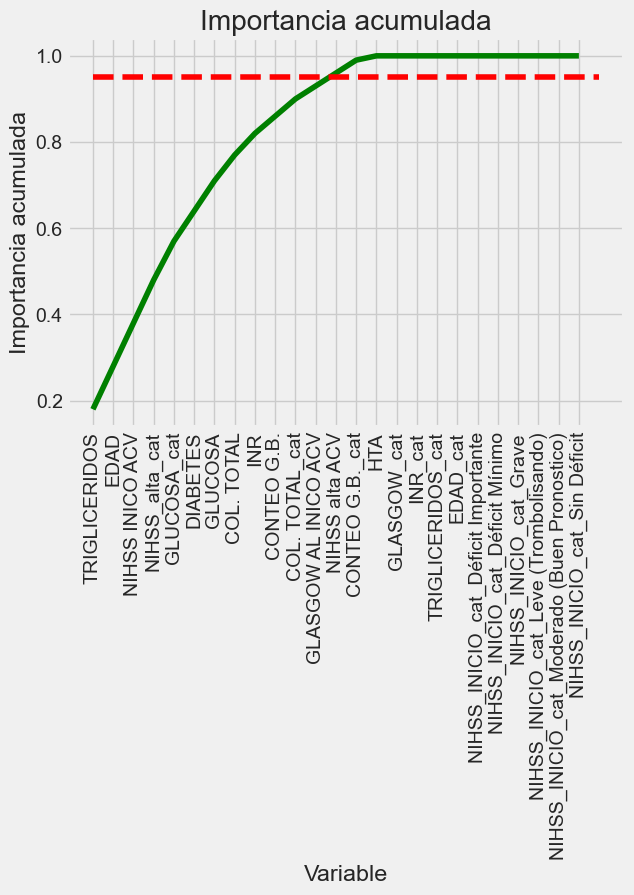

In [88]:
# Lista de funciones ordenadas de mayor a menor importancia
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Importancias acumulativas
cumulative_importances = np.cumsum(sorted_importances)

# Haz un gráfico de líneas
plt.plot(x_values, cumulative_importances, 'g-')

# Dibujar línea al 95% de importancia retenida
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Formato x ticks y etiquetas
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Etiquetas de eje y título
plt.xlabel('Variable'); plt.ylabel('Importancia acumulada'); plt.title('Importancia acumulada');

### Limite el número de características
Ahora reduciremos la cantidad de funciones en uso por el modelo a solo aquellas requeridas para representar el 95% de la importancia. Se debe usar el mismo número de características en los conjuntos de entrenamiento y prueba.

In [89]:
# Encuentre el número de características para una importancia acumulada del 95%
# Agregue 1 porque Python está indexado a cero
print('Número de columna para el 95 % de importancia:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Número de columna para el 95 % de importancia: 13


# Extrapolación con modelos de árboles

Una límitación importante de los árboles de regresión es que no extrapolan fuera del rango de entrenamiento. Cuando se aplica el modelo a una nueva observación, cuyo valor o valores de los predictores son superiores o inferiores a los observados en el entrenamiento, la predicción siempre es la media del nodo más cercano, independientemente de cuanto se aleje el valor. Vease el siguiente ejemplo en el que se entrenan dos modelos, un modelo lineal y un arbol de regresión, y luego se predicen valores de  X  fuera del rango de entrenamiento.

In [90]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

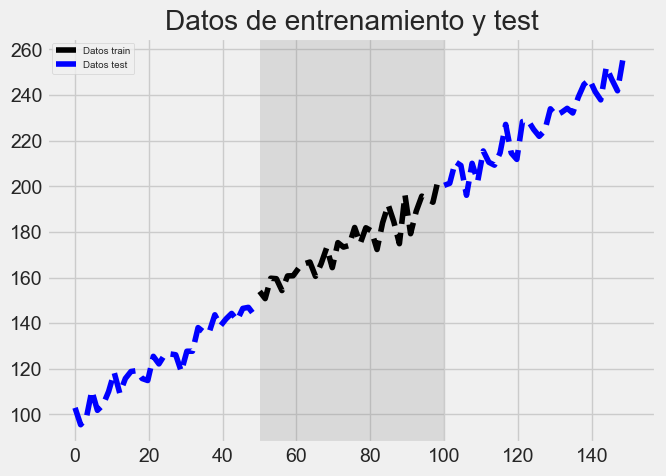

In [91]:
# Datos simulados
# ------------------------------------------------------------------------------
X = np.linspace(0, 150, 100)
y = (X + 100) + np.random.normal(loc=0.0, scale=5.0, size=X.shape)
X_train = X[(X>=50) & (X<100)]
y_train = y[(X>=50) & (X<100)]
X_test_inf = X[X < 50]
y_test_inf = y[X < 50]
X_test_sup = X[X >= 100]
y_test_sup = y[X >= 100]

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(X_train, y_train, c='black', linestyle='dashed', label = "Datos train")
ax.axvspan(50, 100, color='gray', alpha=0.2, lw=0)
ax.plot(X_test_inf, y_test_inf, c='blue', linestyle='dashed', label = "Datos test")
ax.plot(X_test_sup, y_test_sup, c='blue', linestyle='dashed')
ax.set_title("Datos de entrenamiento y test")
plt.legend();

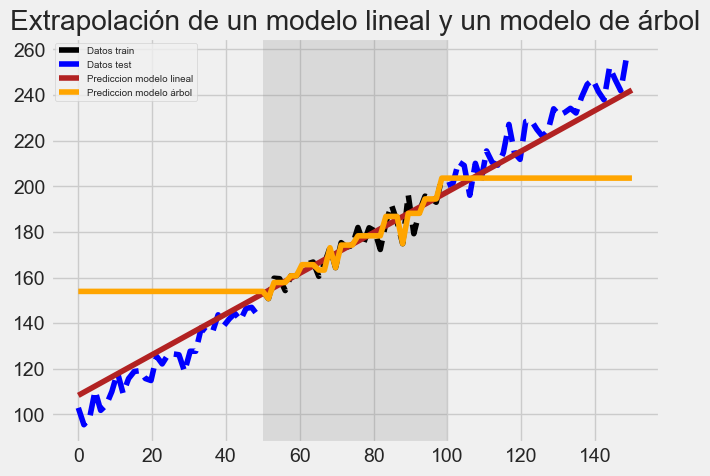

In [92]:
# Modelo lineal
modelo_lineal = LinearRegression()
modelo_lineal.fit(X_train.reshape(-1, 1), y_train)

# Modelo árbol
modelo_tree = DecisionTreeRegressor(max_depth=4)
modelo_tree.fit(X_train.reshape(-1, 1), y_train)

# Predicciones
prediccion_lineal = modelo_lineal.predict(X.reshape(-1, 1))
prediccion_tree   = modelo_tree.predict(X.reshape(-1, 1))

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(X_train, y_train, c='black', linestyle='dashed', label = "Datos train")
ax.axvspan(50, 100, color='gray', alpha=0.2, lw=0)
ax.plot(X_test_inf, y_test_inf, c='blue', linestyle='dashed', label = "Datos test")
ax.plot(X_test_sup, y_test_sup, c='blue', linestyle='dashed')
ax.plot(X, prediccion_lineal, c='firebrick',
        label = "Prediccion modelo lineal")
ax.plot(X, prediccion_tree, c='orange',
        label = "Prediccion modelo árbol")
ax.set_title("Extrapolación de un modelo lineal y un modelo de árbol")
plt.legend();